In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import TweedieRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Load and preprocess
df = pd.read_csv("/content/drive/My Drive/DSO530 Final Project/insurance_train.csv")
df['LC'] = df.apply(lambda row: row['X.15'] / row['X.16'] if row['X.16'] > 0 else 0, axis=1)
for col in ['X.2', 'X.5', 'X.6']:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')

df['age'] = (pd.to_datetime('2019-12-31') - df['X.5']).dt.days // 365
df['license_years'] = (pd.to_datetime('2019-12-31') - df['X.6']).dt.days // 365
df['policy_years'] = (pd.to_datetime('2019-12-31') - df['X.2']).dt.days // 365

# Drop missing
features = [
    'X.7', 'X.8', 'X.9', 'X.10', 'X.11', 'X.12', 'X.13',
    'X.14', 'X.19', 'X.20', 'X.21', 'X.22', 'X.23', 'X.24',
    'X.25', 'X.26', 'X.27', 'X.28', 'age', 'license_years', 'policy_years'
]
df.dropna(subset=features + ['age', 'license_years', 'policy_years'], inplace=True)

# Targets and splits
X = df[features]
y = df['LC']
y_class = (y > 0).astype(int)

# Split full data into train/test
X_train, X_test, y_train, y_test, y_class_train, y_class_test = train_test_split(
    X, y, y_class, test_size=0.2, random_state=42
)

# Create column transformer
categorical_cols = ['X.7', 'X.13', 'X.19', 'X.20', 'X.21', 'X.26', 'X.27']
numeric_cols = [col for col in features if col not in categorical_cols]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Fit on training set only
preprocessor.fit(X_train)
X_train_trans = preprocessor.transform(X_train)
X_test_trans = preprocessor.transform(X_test)

# Fit classifier
clf_model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_model_rf.fit(X_train_trans, y_class_train)
proba_test = clf_model_rf.predict_proba(X_test_trans)[:, 1]

# Regression for y > 0 only
X_train_reg = X_train[y_train > 0]
y_train_reg = y_train[y_train > 0]
X_train_reg_trans = preprocessor.transform(X_train_reg)

X_test_reg = X_test[y_test > 0]
y_test_reg = y_test[y_test > 0]
X_test_reg_trans = preprocessor.transform(X_test_reg)

# Fit Tweedie Regressor
reg_model = TweedieRegressor(power=1.5, alpha=0.5)
reg_model.fit(X_train_reg_trans, y_train_reg)
pred_reg_test = reg_model.predict(X_test_reg_trans)

# Predict class label (0 or 1)
claim_pred = clf_model_rf.predict(X_test_trans)

# Build final prediction array: start with all zeros
final_pred_test = np.zeros(len(X_test))

# Get indices where classifier predicts a claim
claim_indices = np.where(claim_pred == 1)[0]

# Apply regression model only on these samples
X_test_claims = X_test.iloc[claim_indices]
X_test_claims_trans = preprocessor.transform(X_test_claims)
reg_preds_claims = reg_model.predict(X_test_claims_trans)

# Fill in regression results where claim is predicted
final_pred_test[claim_indices] = reg_preds_claims

# Evaluate
mse_test = mean_squared_error(y_test, final_pred_test)
print("MSE on Test Set (Two-Step Model):", mse_test)


# # Final prediction array for test set
# final_pred_test = np.zeros(len(y_test))
# final_pred_test[y_test > 0] = pred_reg_test

# # Evaluate MSE on test set
# mse_test = mean_squared_error(y_test, final_pred_test)
# print("MSE on Test Set:", mse_test)

# # Predict class or prob
# claim_prob = clf_model_rf.predict_proba(X_test_trans)[:, 1]
# claim_pred = (claim_prob > 0.5).astype(int)

# # Predict regression for all
# reg_pred_all = reg_model.predict(X_test_trans)

# # Combine: use regression prediction only if classifier predicts a claim
# final_pred_test = np.where(claim_pred == 1, reg_pred_all, 0)


# mse_test = mean_squared_error(y_test, final_pred_test)
# print("MSE on Test Set:", mse_test)



MSE on Test Set (Two-Step Model): 253501.44862564298


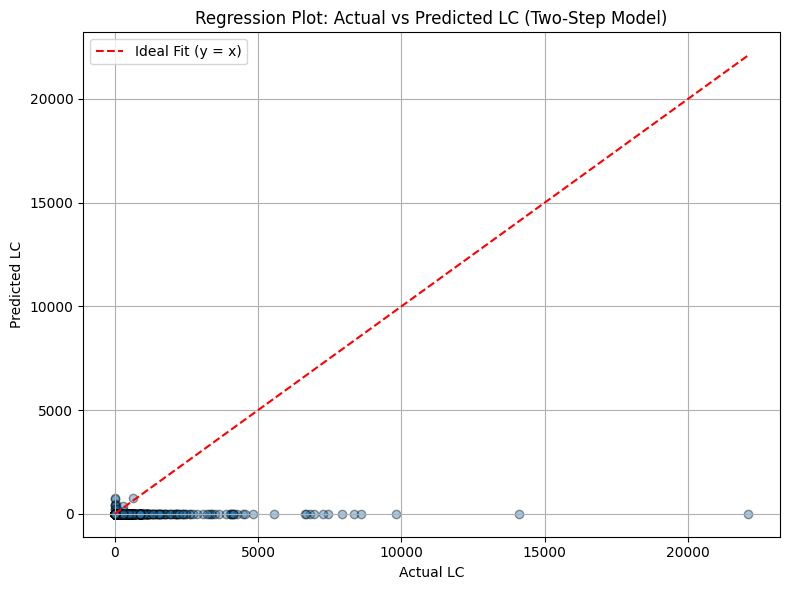

In [ ]:
# ----------------------------
# Regression Plot
# ----------------------------
plt.figure(figsize=(8, 6))
plt.scatter(y_test, final_pred_test, alpha=0.4, edgecolor='k')
plt.plot([0, max(y_test.max(), final_pred_test.max())],
         [0, max(y_test.max(), final_pred_test.max())],
         'r--', label='Ideal Fit (y = x)')
plt.xlabel("Actual LC")
plt.ylabel("Predicted LC")
plt.title("Regression Plot: Actual vs Predicted LC (Two-Step Model)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df.shape

(36858, 32)

In [ ]:
X_train_trans.shape

(29486, 34)

In [ ]:
X_train_reg.shape

(3349, 21)

In [ ]:
X_test_reg.shape

(773, 21)

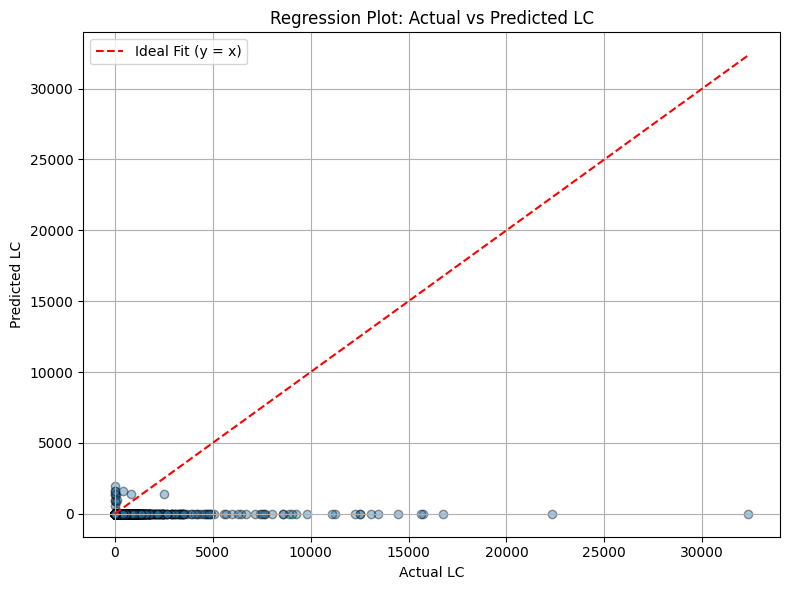

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot: actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, final_pred_test, alpha=0.4, edgecolor='k')
plt.plot([0, max(y_test.max(), final_pred_test.max())],
         [0, max(y_test.max(), final_pred_test.max())],
         'r--', label='Ideal Fit (y = x)')

plt.xlabel("Actual LC")
plt.ylabel("Predicted LC")
plt.title("Regression Plot: Actual vs Predicted LC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


MSE (log-transformed two-step): 253218.04928977782
MAE: 64.66617500062381


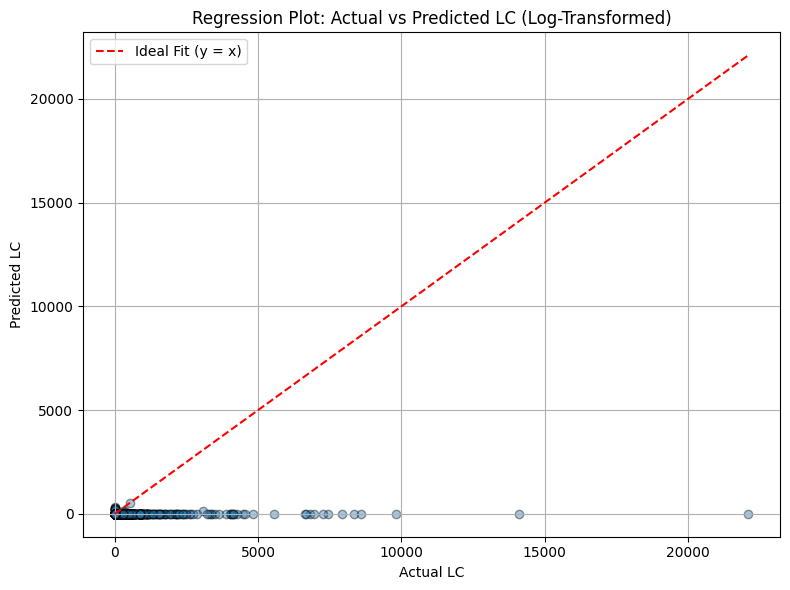

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import TweedieRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("/content/drive/My Drive/DSO530 Final Project/insurance_train.csv")

# Compute LC and log(LC)
df['LC'] = df.apply(lambda row: row['X.15'] / row['X.16'] if row['X.16'] > 0 else 0, axis=1)
df['log_LC'] = np.log1p(df['LC'])  # log(LC + 1)

# Date features
for col in ['X.2', 'X.5', 'X.6']:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')

# Features
features = [
    'X.7', 'X.8', 'X.9', 'X.10', 'X.11', 'X.12', 'X.13',
    'X.14', 'X.19', 'X.20', 'X.21', 'X.22', 'X.23', 'X.24',
    'X.25', 'X.26', 'X.27', 'X.28'
]
df.dropna(subset=features, inplace=True)

# Targets and binary classification
X = df[features]
y = df['LC']
log_y = df['log_LC']
y_class = (y > 0).astype(int)

# Train-test split
X_train, X_test, y_train, y_test, log_y_train, log_y_test, y_class_train, y_class_test = train_test_split(
    X, y, log_y, y_class, test_size=0.2, random_state=42
)

# Preprocessing pipeline
categorical_cols = ['X.7', 'X.13', 'X.19', 'X.20', 'X.21', 'X.26', 'X.27']
numeric_cols = [col for col in features if col not in categorical_cols]
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Transform data
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

# Step 1: Classifier
clf_model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_model_rf.fit(X_train_trans, y_class_train)
claim_pred = clf_model_rf.predict(X_test_trans)

# Step 2: Regressor (on log(LC))
# Filter log_y_train with same index as y_train
X_train_reg = X_train[y_train > 0]
log_y_train_reg = log_y_train[y_train > 0]
X_train_reg_trans = preprocessor.transform(X_train_reg)

reg_model = TweedieRegressor(power=1.5, alpha=0.5)
reg_model.fit(X_train_reg_trans, log_y_train_reg)

# Final prediction logic
final_pred_test = np.zeros(len(X_test))
claim_indices = np.where(claim_pred == 1)[0]
X_test_claims = X_test.iloc[claim_indices]
X_test_claims_trans = preprocessor.transform(X_test_claims)
log_preds = reg_model.predict(X_test_claims_trans)
reg_preds_claims = np.expm1(log_preds)  # reverse of log1p
final_pred_test[claim_indices] = reg_preds_claims

# Evaluation
mse = mean_squared_error(y_test, final_pred_test)
mae = mean_absolute_error(y_test, final_pred_test)
print("MSE (log-transformed two-step):", mse)
print("MAE:", mae)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, final_pred_test, alpha=0.4, edgecolor='k')
plt.plot([0, max(y_test.max(), final_pred_test.max())],
         [0, max(y_test.max(), final_pred_test.max())],
         'r--', label='Ideal Fit (y = x)')
plt.xlabel("Actual LC")
plt.ylabel("Predicted LC")
plt.title("Regression Plot: Actual vs Predicted LC (Log-Transformed)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1309
[LightGBM] [Info] Number of data points in the train set: 3349, number of used features: 33
[LightGBM] [Info] Start training from score 636.786008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


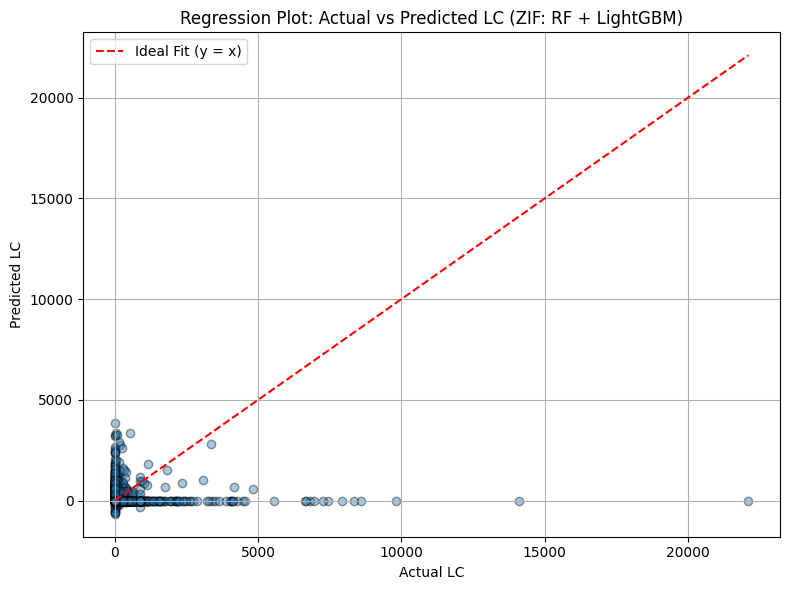

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor

# Load data
df = pd.read_csv("/content/drive/My Drive/DSO530 Final Project/insurance_train.csv")

# Compute LC
df['LC'] = df.apply(lambda row: row['X.15'] / row['X.16'] if row['X.16'] > 0 else 0, axis=1)

# Date features
for col in ['X.2', 'X.5', 'X.6']:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
df['age'] = (pd.to_datetime('2019-12-31') - df['X.5']).dt.days // 365
df['license_years'] = (pd.to_datetime('2019-12-31') - df['X.6']).dt.days // 365
df['policy_years'] = (pd.to_datetime('2019-12-31') - df['X.2']).dt.days // 365

# Features
features = [
    'X.7', 'X.8', 'X.9', 'X.10', 'X.11', 'X.12', 'X.13',
    'X.14', 'X.19', 'X.20', 'X.21', 'X.22', 'X.23', 'X.24',
    'X.25', 'X.26', 'X.27', 'X.28', 'age', 'license_years', 'policy_years'
]
df.dropna(subset=features, inplace=True)

# Targets and binary classifier target
X = df[features]
y = df['LC']
y_class = (y > 0).astype(int)

# Train/test split
X_train, X_test, y_train, y_test, y_class_train, y_class_test = train_test_split(
    X, y, y_class, test_size=0.2, random_state=42
)

# Preprocessing
categorical_cols = ['X.7', 'X.13', 'X.19', 'X.20', 'X.21', 'X.26', 'X.27']
numeric_cols = [col for col in features if col not in categorical_cols]
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Fit on training set only
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

# Step 1: Classifier
clf_model = RandomForestClassifier(n_estimators=100, random_state=42)
clf_model.fit(X_train_trans, y_class_train)

# Predict probabilities and classify with threshold 0.3
claim_prob = clf_model.predict_proba(X_test_trans)[:, 1]
claim_pred = (claim_prob > 0.3).astype(int)

# Step 2: LightGBM Regressor (only on y_train > 0)
X_train_reg = X_train[y_train > 0]
y_train_reg = y_train[y_train > 0]
X_train_reg_trans = preprocessor.transform(X_train_reg)

reg_model = LGBMRegressor(
    learning_rate=0.05,
    n_estimators=300,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
reg_model.fit(X_train_reg_trans, y_train_reg)

# Final prediction array
final_pred_test = np.zeros(len(X_test))
claim_indices = np.where(claim_pred == 1)[0]
X_test_claims = X_test.iloc[claim_indices]
X_test_claims_trans = preprocessor.transform(X_test_claims)
reg_preds_claims = reg_model.predict(X_test_claims_trans)
final_pred_test[claim_indices] = reg_preds_claims

# Evaluation
mse = mean_squared_error(y_test, final_pred_test)
mae = mean_absolute_error(y_test, final_pred_test)
print("MSE on Test Set (ZIF with LightGBM):", mse)
print("MAE:", mae)

# Regression plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, final_pred_test, alpha=0.4, edgecolor='k')
plt.plot([0, max(y_test.max(), final_pred_test.max())],
         [0, max(y_test.max(), final_pred_test.max())],
         'r--', label='Ideal Fit (y = x)')
plt.xlabel("Actual LC")
plt.ylabel("Predicted LC")
plt.title("Regression Plot: Actual vs Predicted LC (ZIF: RF + LightGBM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error

# --- Classifier Performance ---
# True vs predicted claim presence
print("\n--- Classifier Metrics ---")
acc = accuracy_score(y_class_test, claim_pred)
auc = roc_auc_score(y_class_test, claim_prob)
print("Classifier Accuracy:", acc)
print("Classifier ROC-AUC:", auc)

# --- Regressor Performance (on predicted claims only) ---
print("\n--- Regressor Metrics ---")
# True LC values for those predicted as claims
true_lc_for_claims = y_test.iloc[claim_indices]
pred_lc_for_claims = final_pred_test[claim_indices]

# Regressor-only MSE/MAE
mse_reg = mean_squared_error(true_lc_for_claims, pred_lc_for_claims)
mae_reg = mean_absolute_error(true_lc_for_claims, pred_lc_for_claims)
print("Regressor MSE (predicted claims only):", mse_reg)
print("Regressor MAE (predicted claims only):", mae_reg)

# --- Overall MSE ---
print("\n--- Combined Model ---")
print("Overall MSE:", mse)
print("Overall MAE:", mae)



--- Classifier Metrics ---
Classifier Accuracy: 0.8758817145957678
Classifier ROC-AUC: 0.7307905839353526

--- Regressor Metrics ---
Regressor MSE (predicted claims only): 871197.9983654243
Regressor MAE (predicted claims only): 660.4046003463399

--- Combined Model ---
Overall MSE: 285366.3714700204
Overall MAE: 91.13266318151624



--- Classifier Metrics ---
Accuracy: 0.8758817145957678
ROC-AUC: 0.7307905839353526

--- Regressor Metrics ---
Regressor MSE (claims only): 243156.63610414407
Regressor MAE (claims only): 265.977806174282

--- Combined Model ---
Overall MSE: 253674.6478182031
Overall MAE: 71.22941203772817


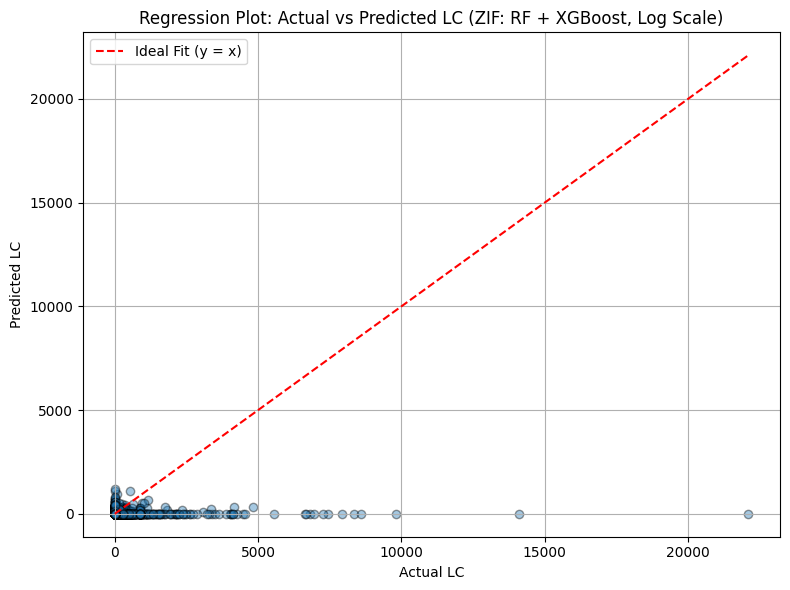

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, roc_auc_score
from xgboost import XGBRegressor

# Load dataset
df = pd.read_csv("/content/drive/My Drive/DSO530 Final Project/insurance_train.csv")

# Compute LC and log_LC
df['LC'] = df.apply(lambda row: row['X.15'] / row['X.16'] if row['X.16'] > 0 else 0, axis=1)
df['log_LC'] = np.log1p(df['LC'])

# Date features
for col in ['X.2', 'X.5', 'X.6']:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
df['age'] = (pd.to_datetime('2019-12-31') - df['X.5']).dt.days // 365
df['license_years'] = (pd.to_datetime('2019-12-31') - df['X.6']).dt.days // 365
df['policy_years'] = (pd.to_datetime('2019-12-31') - df['X.2']).dt.days // 365

# Feature set
features = [
    'X.7', 'X.8', 'X.9', 'X.10', 'X.11', 'X.12', 'X.13',
    'X.14', 'X.19', 'X.20', 'X.21', 'X.22', 'X.23', 'X.24',
    'X.25', 'X.26', 'X.27', 'X.28', 'age', 'license_years', 'policy_years'
]
df.dropna(subset=features, inplace=True)

# Targets
X = df[features]
y = df['LC']
log_y = df['log_LC']
y_class = (y > 0).astype(int)

# Split
X_train, X_test, y_train, y_test, log_y_train, log_y_test, y_class_train, y_class_test = train_test_split(
    X, y, log_y, y_class, test_size=0.2, random_state=42
)

# Preprocessing
categorical_cols = ['X.7', 'X.13', 'X.19', 'X.20', 'X.21', 'X.26', 'X.27']
numeric_cols = [col for col in features if col not in categorical_cols]
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

# --- Step 1: Random Forest Classifier ---
clf_model = RandomForestClassifier(n_estimators=100, random_state=42)
clf_model.fit(X_train_trans, y_class_train)

claim_prob = clf_model.predict_proba(X_test_trans)[:, 1]
claim_pred = (claim_prob > 0.3).astype(int)  # lower threshold

# --- Step 2: XGBoost Regressor on log(LC) ---
X_train_reg = X_train[y_train > 0]
log_y_train_reg = log_y_train[y_train > 0]
X_train_reg_trans = preprocessor.transform(X_train_reg)

reg_model = XGBRegressor(
    learning_rate=0.05,
    n_estimators=300,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
reg_model.fit(X_train_reg_trans, log_y_train_reg)

# --- Final Prediction Logic ---
final_pred_test = np.zeros(len(X_test))
claim_indices = np.where(claim_pred == 1)[0]
X_test_claims = X_test.iloc[claim_indices]
X_test_claims_trans = preprocessor.transform(X_test_claims)

log_preds = reg_model.predict(X_test_claims_trans)
reg_preds_claims = np.expm1(log_preds)  # inverse of log1p
final_pred_test[claim_indices] = reg_preds_claims

# --- Evaluation ---

# Classifier metrics
print("\n--- Classifier Metrics ---")
print("Accuracy:", accuracy_score(y_class_test, claim_pred))
print("ROC-AUC:", roc_auc_score(y_class_test, claim_prob))

# Regressor metrics
print("\n--- Regressor Metrics ---")
true_lc_claims = y_test.iloc[claim_indices]
mse_reg = mean_squared_error(true_lc_claims, reg_preds_claims)
mae_reg = mean_absolute_error(true_lc_claims, reg_preds_claims)
print("Regressor MSE (claims only):", mse_reg)
print("Regressor MAE (claims only):", mae_reg)

# Combined model
print("\n--- Combined Model ---")
mse_total = mean_squared_error(y_test, final_pred_test)
mae_total = mean_absolute_error(y_test, final_pred_test)
print("Overall MSE:", mse_total)
print("Overall MAE:", mae_total)

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, final_pred_test, alpha=0.4, edgecolor='k')
plt.plot([0, max(y_test.max(), final_pred_test.max())],
         [0, max(y_test.max(), final_pred_test.max())],
         'r--', label='Ideal Fit (y = x)')
plt.xlabel("Actual LC")
plt.ylabel("Predicted LC")
plt.title("Regression Plot: Actual vs Predicted LC (ZIF: RF + XGBoost, Log Scale)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1309
[LightGBM] [Info] Number of data points in the train set: 3349, number of used features: 33
[LightGBM] [Info] Start training from score 5.411996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

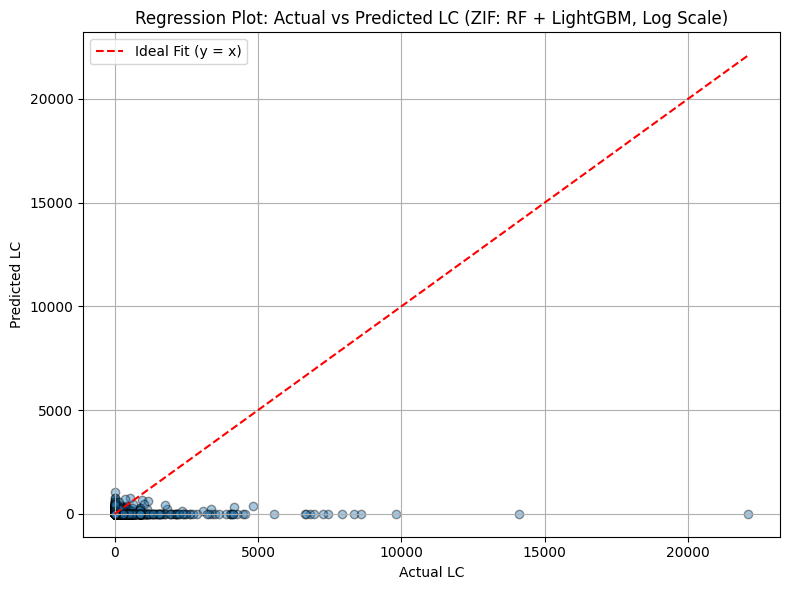

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, roc_auc_score
from lightgbm import LGBMRegressor

# Load dataset
df = pd.read_csv("/content/drive/My Drive/DSO530 Final Project/insurance_train.csv")

# Compute LC and log_LC
df['LC'] = df.apply(lambda row: row['X.15'] / row['X.16'] if row['X.16'] > 0 else 0, axis=1)
df['log_LC'] = np.log1p(df['LC'])

# Date features
for col in ['X.2', 'X.5', 'X.6']:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
df['age'] = (pd.to_datetime('2019-12-31') - df['X.5']).dt.days // 365
df['license_years'] = (pd.to_datetime('2019-12-31') - df['X.6']).dt.days // 365
df['policy_years'] = (pd.to_datetime('2019-12-31') - df['X.2']).dt.days // 365

# Features
features = [
    'X.7', 'X.8', 'X.9', 'X.10', 'X.11', 'X.12', 'X.13',
    'X.14', 'X.19', 'X.20', 'X.21', 'X.22', 'X.23', 'X.24',
    'X.25', 'X.26', 'X.27', 'X.28', 'age', 'license_years', 'policy_years'
]
df.dropna(subset=features, inplace=True)

# Targets
X = df[features]
y = df['LC']
log_y = df['log_LC']
y_class = (y > 0).astype(int)

# Split
X_train, X_test, y_train, y_test, log_y_train, log_y_test, y_class_train, y_class_test = train_test_split(
    X, y, log_y, y_class, test_size=0.2, random_state=42
)

# Preprocessing
categorical_cols = ['X.7', 'X.13', 'X.19', 'X.20', 'X.21', 'X.26', 'X.27']
numeric_cols = [col for col in features if col not in categorical_cols]
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

# --- Step 1: Random Forest Classifier ---
clf_model = RandomForestClassifier(n_estimators=100, random_state=42)
clf_model.fit(X_train_trans, y_class_train)
claim_prob = clf_model.predict_proba(X_test_trans)[:, 1]
claim_pred = (claim_prob > 0.3).astype(int)

# --- Step 2: LightGBM Regressor on log(LC) ---
X_train_reg = X_train[y_train > 0]
log_y_train_reg = log_y_train[y_train > 0]
X_train_reg_trans = preprocessor.transform(X_train_reg)

reg_model = LGBMRegressor(
    learning_rate=0.05,
    n_estimators=300,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
reg_model.fit(X_train_reg_trans, log_y_train_reg)

# --- Final Prediction Logic ---
final_pred_test = np.zeros(len(X_test))
claim_indices = np.where(claim_pred == 1)[0]
X_test_claims = X_test.iloc[claim_indices]
X_test_claims_trans = preprocessor.transform(X_test_claims)

log_preds = reg_model.predict(X_test_claims_trans)
reg_preds_claims = np.expm1(log_preds)  # back-transform from log1p
final_pred_test[claim_indices] = reg_preds_claims

# --- Evaluation ---

# Classifier metrics
print("\n--- Classifier Metrics ---")
print("Accuracy:", accuracy_score(y_class_test, claim_pred))
print("ROC-AUC:", roc_auc_score(y_class_test, claim_prob))

# Regressor metrics
print("\n--- Regressor Metrics ---")
true_lc_claims = y_test.iloc[claim_indices]
mse_reg = mean_squared_error(true_lc_claims, reg_preds_claims)
mae_reg = mean_absolute_error(true_lc_claims, reg_preds_claims)
print("Regressor MSE (claims only):", mse_reg)
print("Regressor MAE (claims only):", mae_reg)

# Combined model metrics
print("\n--- Combined Model ---")
mse_total = mean_squared_error(y_test, final_pred_test)
mae_total = mean_absolute_error(y_test, final_pred_test)
print("Overall MSE:", mse_total)
print("Overall MAE:", mae_total)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, final_pred_test, alpha=0.4, edgecolor='k')
plt.plot([0, max(y_test.max(), final_pred_test.max())],
         [0, max(y_test.max(), final_pred_test.max())],
         'r--', label='Ideal Fit (y = x)')
plt.xlabel("Actual LC")
plt.ylabel("Predicted LC")
plt.title("Regression Plot: Actual vs Predicted LC (ZIF: RF + LightGBM, Log Scale)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
y.describe()

,LC
count,36858.00000
mean,70.73371
std,845.26958
min,0.00000
25%,0.00000
50%,0.00000
75%,0.00000
max,118142.59000


In [ ]:
final_pred_test

array([0., 0., 0., ..., 0., 0., 0.])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1553
[LightGBM] [Info] Number of data points in the train set: 29486, number of used features: 34
[LightGBM] [Info] Start training from score 4.281180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


MSE on Test Set (LightGBM Tweedie): 247347.5705958039


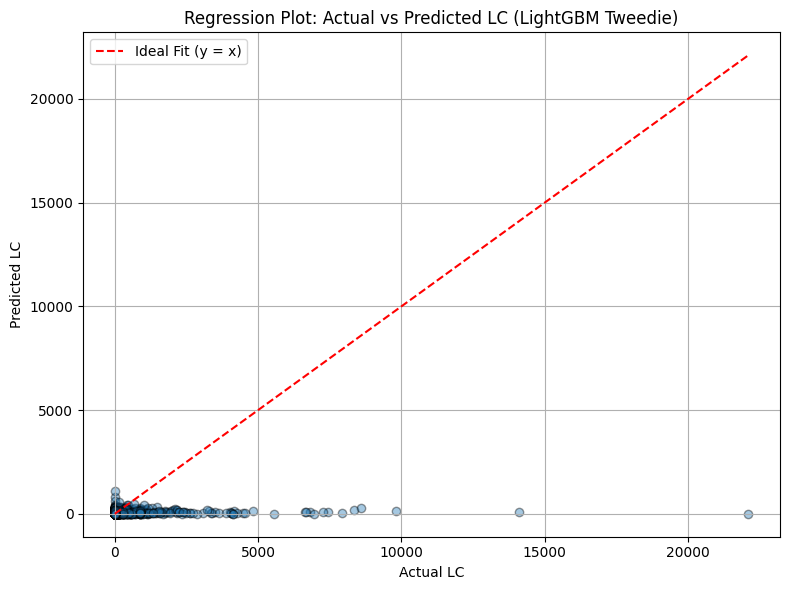

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error

# Load data
df = pd.read_csv("/content/drive/My Drive/DSO530 Final Project/insurance_train.csv")

# Compute LC
df['LC'] = df.apply(lambda row: row['X.15'] / row['X.16'] if row['X.16'] > 0 else 0, axis=1)

# Dates → derived features
for col in ['X.2', 'X.5', 'X.6']:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
df['age'] = (pd.to_datetime('2019-12-31') - df['X.5']).dt.days // 365
df['license_years'] = (pd.to_datetime('2019-12-31') - df['X.6']).dt.days // 365
df['policy_years'] = (pd.to_datetime('2019-12-31') - df['X.2']).dt.days // 365

# Feature set
features = [
    'X.7', 'X.8', 'X.9', 'X.10', 'X.11', 'X.12', 'X.13',
    'X.14', 'X.19', 'X.20', 'X.21', 'X.22', 'X.23', 'X.24',
    'X.25', 'X.26', 'X.27', 'X.28', 'age', 'license_years', 'policy_years'
]

# Drop rows with missing values
df.dropna(subset=features, inplace=True)

# Define X and y
X = df[features]
y = df['LC']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
categorical_cols = ['X.7', 'X.13', 'X.19', 'X.20', 'X.21', 'X.26', 'X.27']
numeric_cols = [col for col in features if col not in categorical_cols]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Fit and transform
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

# ----------------------------
# LightGBM Regressor with Tweedie
# ----------------------------
reg_model = LGBMRegressor(
    objective='tweedie',
    tweedie_variance_power=1.5,
    learning_rate=0.05,
    n_estimators=300,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
reg_model.fit(X_train_trans, y_train)

# Predict on test set
y_pred = reg_model.predict(X_test_trans)

# MSE evaluation
mse = mean_squared_error(y_test, y_pred)
print("MSE on Test Set (LightGBM Tweedie):", mse)

# ----------------------------
# Regression Plot
# ----------------------------
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.4, edgecolor='k')
plt.plot([0, max(y_test.max(), y_pred.max())],
         [0, max(y_test.max(), y_pred.max())],
         'r--', label='Ideal Fit (y = x)')
plt.xlabel("Actual LC")
plt.ylabel("Predicted LC")
plt.title("Regression Plot: Actual vs Predicted LC (LightGBM Tweedie)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'regressor__alpha': 1.0, 'regressor__power': 1.8}
MSE on Test Set: 248567.88161407298


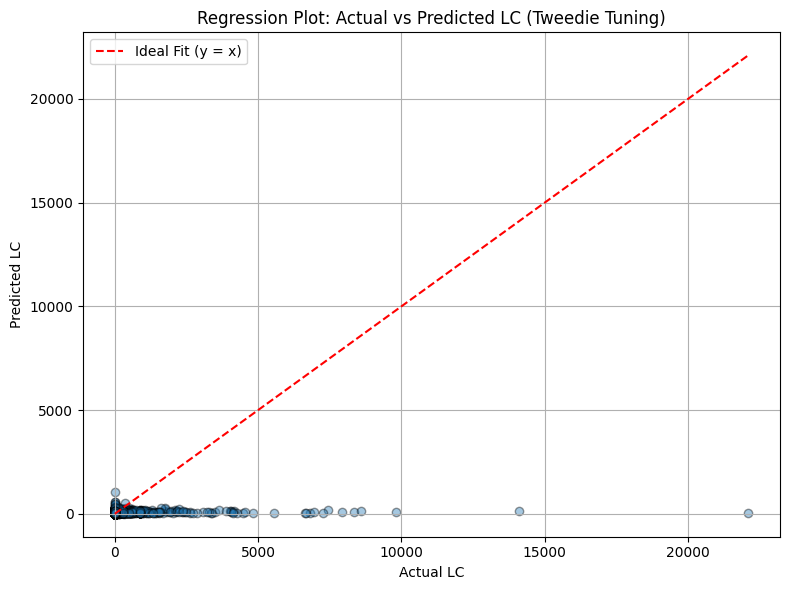

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import TweedieRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Load and preprocess
df = pd.read_csv("/content/drive/My Drive/DSO530 Final Project/insurance_train.csv")
df['LC'] = df.apply(lambda row: row['X.15'] / row['X.16'] if row['X.16'] > 0 else 0, axis=1)

for col in ['X.2', 'X.5', 'X.6']:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')

df['age'] = (pd.to_datetime('2019-12-31') - df['X.5']).dt.days // 365
df['license_years'] = (pd.to_datetime('2019-12-31') - df['X.6']).dt.days // 365
df['policy_years'] = (pd.to_datetime('2019-12-31') - df['X.2']).dt.days // 365

# Drop missing values
features = [
    'X.7', 'X.8', 'X.9', 'X.10', 'X.11', 'X.12', 'X.13',
    'X.14', 'X.19', 'X.20', 'X.21', 'X.22', 'X.23', 'X.24',
    'X.25', 'X.26', 'X.27', 'X.28', 'age', 'license_years', 'policy_years'
]
df.dropna(subset=features, inplace=True)

# Split into train/test
X = df[features]
y = df['LC']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
categorical_cols = ['X.7', 'X.13', 'X.19', 'X.20', 'X.21', 'X.26', 'X.27']
numeric_cols = [col for col in features if col not in categorical_cols]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Full pipeline with Tweedie Regressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', TweedieRegressor())
])

# Grid search over power and alpha
param_grid = {
    'regressor__power': [1.1, 1.3, 1.5, 1.8],
    'regressor__alpha': [0.01, 0.1, 1.0]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best model and MSE
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Best Parameters:", grid_search.best_params_)
print("MSE on Test Set:", mse)

# ----------------------------
# Regression Plot
# ----------------------------
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.4, edgecolor='k')
plt.plot([0, max(y_test.max(), y_pred.max())],
         [0, max(y_test.max(), y_pred.max())],
         'r--', label='Ideal Fit (y = x)')
plt.xlabel("Actual LC")
plt.ylabel("Predicted LC")
plt.title("Regression Plot: Actual vs Predicted LC (Tweedie Tuning)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier  # updated here
from sklearn.model_selection import train_test_split
from sklearn.linear_model import TweedieRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Load and preprocess
df = pd.read_csv("/content/drive/My Drive/DSO530 Final Project/insurance_train.csv")
df['LC'] = df.apply(lambda row: row['X.15'] / row['X.16'] if row['X.16'] > 0 else 0, axis=1)

for col in ['X.2', 'X.5', 'X.6']:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')

df['age'] = (pd.to_datetime('2019-12-31') - df['X.5']).dt.days // 365
df['license_years'] = (pd.to_datetime('2019-12-31') - df['X.6']).dt.days // 365
df['policy_years'] = (pd.to_datetime('2019-12-31') - df['X.2']).dt.days // 365

# Drop missing
features = [
    'X.7', 'X.8', 'X.9', 'X.10', 'X.11', 'X.12', 'X.13',
    'X.14', 'X.19', 'X.20', 'X.21', 'X.22', 'X.23', 'X.24',
    'X.25', 'X.26', 'X.27', 'X.28', 'age', 'license_years', 'policy_years'
]
df.dropna(subset=features + ['age', 'license_years', 'policy_years'], inplace=True)

# Targets and splits
X = df[features]
y = df['LC']
y_class = (y > 0).astype(int)

X_train, X_test, y_train, y_test, y_class_train, y_class_test = train_test_split(
    X, y, y_class, test_size=0.2, random_state=42
)

# Preprocessing
categorical_cols = ['X.7', 'X.13', 'X.19', 'X.20', 'X.21', 'X.26', 'X.27']
numeric_cols = [col for col in features if col not in categorical_cols]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Transform features
preprocessor.fit(X_train)
X_train_trans = preprocessor.transform(X_train)
X_test_trans = preprocessor.transform(X_test)

# ---------------------------
# CLASSIFIER: Gradient Boosting
# ---------------------------
clf_model_gb = GradientBoostingClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
clf_model_gb.fit(X_train_trans, y_class_train)

# Predict probabilities for claim occurrence
claim_prob = clf_model_gb.predict_proba(X_test_trans)[:, 1]
claim_pred = (claim_prob > 0.5).astype(int)

# ---------------------------
# REGRESSOR: Tweedie on LC > 0
# ---------------------------
X_train_reg = X_train[y_train > 0]
y_train_reg = y_train[y_train > 0]
X_train_reg_trans = preprocessor.transform(X_train_reg)

reg_model = TweedieRegressor(power=1.5, alpha=0.5)
reg_model.fit(X_train_reg_trans, y_train_reg)

# Predict regression for all
reg_pred_all = reg_model.predict(X_test_trans)

# Combine: use regression only if classifier predicts a claim
final_pred_test = np.where(claim_pred == 1, reg_pred_all, 0)

# Evaluate
mse_test = mean_squared_error(y_test, final_pred_test)
print("MSE on Test Set (Gradient Boosting + Tweedie):", mse_test)


MSE on Test Set (Gradient Boosting + Tweedie): 254126.85501560644


In [ ]:
# ----- HALC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import TweedieRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Load and preprocess
df = pd.read_csv("/content/drive/My Drive/DSO530 Final Project/insurance_train.csv")

# Define HALC
df['HALC'] = df.apply(lambda row: (row['X.15'] / row['X.16']) * row['X.18'] if row['X.16'] > 0 else 0, axis=1)

# Convert date columns
for col in ['X.2', 'X.5', 'X.6']:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')

# Feature engineering
df['age'] = (pd.to_datetime('2019-12-31') - df['X.5']).dt.days // 365
df['license_years'] = (pd.to_datetime('2019-12-31') - df['X.6']).dt.days // 365
df['policy_years'] = (pd.to_datetime('2019-12-31') - df['X.2']).dt.days // 365

# Drop rows with missing values
features = [
    'X.7', 'X.8', 'X.9', 'X.10', 'X.11', 'X.12', 'X.13',
    'X.14', 'X.19', 'X.20', 'X.21', 'X.22', 'X.23', 'X.24',
    'X.25', 'X.26', 'X.27', 'X.28', 'age', 'license_years', 'policy_years'
]
df.dropna(subset=features + ['age', 'license_years', 'policy_years'], inplace=True)

# Define targets and binary class
X = df[features]
y = df['HALC']
y_class = (y > 0).astype(int)

# Train-test split
X_train, X_test, y_train, y_test, y_class_train, y_class_test = train_test_split(
    X, y, y_class, test_size=0.2, random_state=42
)

# Preprocessing pipeline
categorical_cols = ['X.7', 'X.13', 'X.19', 'X.20', 'X.21', 'X.26', 'X.27']
numeric_cols = [col for col in features if col not in categorical_cols]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Fit and transform
preprocessor.fit(X_train)
X_train_trans = preprocessor.transform(X_train)
X_test_trans = preprocessor.transform(X_test)

# ---------------------------
# Step 1: Classifier (Random Forest)
# ---------------------------
clf_model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_model_rf.fit(X_train_trans, y_class_train)

# Predict claim probabilities
claim_prob = clf_model_rf.predict_proba(X_test_trans)[:, 1]
claim_pred = (claim_prob > 0.5).astype(int)

# ---------------------------
# Step 2: Regressor (Tweedie on HALC > 0)
# ---------------------------
X_train_reg = X_train[y_train > 0]
y_train_reg = y_train[y_train > 0]
X_train_reg_trans = preprocessor.transform(X_train_reg)

reg_model = TweedieRegressor(power=1.5, alpha=0.5)
reg_model.fit(X_train_reg_trans, y_train_reg)

# Predict regression values for all test rows
reg_pred_all = reg_model.predict(X_test_trans)

# ---------------------------
# Combine Step: Classifier + Regressor
# ---------------------------
final_pred_test = np.where(claim_pred == 1, reg_pred_all, 0)

# Evaluate
mse_test = mean_squared_error(y_test, final_pred_test)
print("MSE on Test Set (HALC, RF + Tweedie):", mse_test)


MSE on Test Set (HALC, RF + Tweedie): 762600.6768672897


In [ ]:
y.describe()

,HALC
count,36858.000000
mean,129.891777
std,1678.916514
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,236285.180000


In [ ]:
# prompt: find the percentage where y = 0

# Calculate the percentage of times y is equal to 0
percentage_y_zero = (y_test == 0).sum() / len(y_test) * 100
print(f"Percentage of times y is equal to 0 in the test set: {percentage_y_zero:.2f}%")


Percentage of times y is equal to 0 in the test set: 89.57%


In [ ]:
# prompt: find the rows where y is not zero

# Access the y_test Series (assuming it's defined in your existing code)
rows_not_zero = y_test[y_test != 0]

# Print the rows where 'y' is not zero
rows_not_zero


,HALC
4462,705.88980
34985,432.57795
35397,7417.21500
14590,89.28000
13378,87.41410
...,...
12504,93.32615
15945,311.21520
4589,416.18250
29645,394.61660


In [ ]:
# Re-run all steps again after environment reset
import pandas as pd
import numpy as np
from sklearn.linear_model import TweedieRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Reload dataset
df = pd.read_csv("/content/drive/My Drive/DSO530 Final Project/insurance_train.csv")
# Compute LC and filter for LC > 0
df['LC'] = df.apply(lambda row: row['X.15'] / row['X.16'] if row['X.16'] > 0 else 0, axis=1)

# Date conversions and feature engineering
for col in ['X.2', 'X.5', 'X.6']:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')

df['age'] = (pd.to_datetime('2019-12-31') - df['X.5']).dt.days // 365
df['license_years'] = (pd.to_datetime('2019-12-31') - df['X.6']).dt.days // 365
df['policy_years'] = (pd.to_datetime('2019-12-31') - df['X.2']).dt.days // 365

# Define features and target
feature_cols = ['X.7', 'X.8', 'X.9', 'X.10', 'X.11', 'X.12', 'X.13',
                'X.14', 'X.19', 'X.20', 'X.21', 'X.22', 'X.23', 'X.24',
                'X.25', 'X.26', 'X.27', 'X.28', 'age', 'license_years', 'policy_years']
X = df[feature_cols]
y = df['LC']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Pipeline with TweedieRegressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', TweedieRegressor(power=1.5, alpha=0.0, link='log'))
])

# Grid search setup
param_grid = {
    'regressor__power': [1.1, 1.3, 1.5, 1.7, 1.9],
    'regressor__alpha': [0.001, 0.01, 0.1, 1.0]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_mse = -grid_search.best_score_
best_params = grid_search.best_params_

best_mse, best_params


(np.float64(684000.2187055827),
 {'regressor__alpha': 1.0, 'regressor__power': 1.9})

# LASSO

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer

In [ ]:
# Load data
df = pd.read_csv("/content/drive/My Drive/DSO530 Final Project/insurance_train.csv")


# === Compute Loss Cost (LC), safe divide ===
df['LC'] = df.apply(lambda row: row['X.15'] / row['X.16'] if row['X.16'] > 0 else 0, axis=1)

df['Claim_Status'] = (df['X.16'] > 0).astype(int)

# === Date Conversion and Age Feature Engineering ===
for col in ['X.2', 'X.5', 'X.6']:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')

today = pd.to_datetime('today')
df['age'] = (today - df['X.5']).dt.days // 365
df['license_years'] = (today - df['X.6']).dt.days // 365
df['policy_years'] = (today - df['X.2']).dt.days // 365

# === Feature Selection ===
features = [
    'X.7', 'X.8', 'X.9', 'X.10', 'X.11', 'X.12', 'X.13', 'X.14',
    'X.19', 'X.20', 'X.21', 'X.22', 'X.23', 'X.24', 'X.25',
    'X.26', 'X.27', 'X.28', 'age', 'license_years', 'policy_years'
]

categorical_features = ['X.7', 'X.13', 'X.19', 'X.20', 'X.21', 'X.27']
numeric_features = list(set(features) - set(categorical_features))



preprocessor = ColumnTransformer([
    ('num', PowerTransformer(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

# Drop missing
df.dropna(subset=features + ['Claim_Status'], inplace=True)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


X = df[features]
y = df['LC']
X_transformed = preprocessor.fit_transform(X)


# ----------------------------
# Lasso Regression with CV
# ----------------------------
lasso = Lasso(max_iter=10000)

# Define alpha values to test
lasso_param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]
}

# Grid search with cross-validation (5-fold)
lasso_grid_search = GridSearchCV(estimator=lasso,
                                  param_grid=lasso_param_grid,
                                  scoring='neg_mean_squared_error',
                                  cv=5,
                                  n_jobs=-1,
                                  verbose=1)

lasso_grid_search.fit(X_transformed, y)

# Best model
best_lasso = lasso_grid_search.best_estimator_
best_alpha = lasso_grid_search.best_params_['alpha']
print(f"✅ Best alpha for Lasso: {best_alpha}")

# Extract non-zero feature indices
important_features = np.where(best_lasso.coef_ != 0)[0]
lasso_coefficients = best_lasso.coef_

# Feature names from preprocessor
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

# Classify features
non_zero_features = [all_feature_names[i] for i in important_features]
zero_features = [all_feature_names[i] for i in range(len(all_feature_names)) if i not in important_features]

# Print results
print(f"🔍 Number of selected (non-zero) features: {len(non_zero_features)}")
print(f"✅ Selected features: {non_zero_features}\n")

print(f"❌ Number of eliminated (zero) features: {len(zero_features)}")
print(f"Eliminated features: {zero_features}")

# Final selected feature matrix
X_transformed_selected = X_transformed[:, important_features]


/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:188: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
✅ Best alpha for Lasso: 1.0
🔍 Number of selected (non-zero) features: 13
✅ Selected features: ['policy_years', 'X.10', 'X.22', 'X.9', 'X.25', 'license_years', 'X.8', 'X.23', 'X.14', 'X.12', 'age', 'X.7_1', 'X.13_1']

❌ Number of eliminated (zero) features: 10
Eliminated features: ['X.28', 'X.11', 'X.26', 'X.24', 'X.19_2', 'X.19_3', 'X.19_4', 'X.20_1', 'X.21_1', 'X.27_P']


In [ ]:

# LightGBM base model
lgb_model = LGBMRegressor(objective='tweedie', random_state=42)

# Pipeline
pipeline = Pipeline([
    ('regressor', lgb_model)
])

# Parameter grid
param_grid = {
    'regressor__reg_alpha': [0.01, 0.1, 0.5, 1.0],
    'regressor__tweedie_variance_power': [1.0, 1.5, 1.9]
}

# GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_transformed_selected, y)

# Best model and results
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_transformed_selected)
mse = mean_squared_error(y, y_pred)

# Output
print("Best Parameters:", grid_search.best_params_)
print("MSE (CV Tuned Model):", mse)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 36858, number of used features: 13
[LightGBM] [Info] Start training from score 4.258922


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best Parameters: {'regressor__reg_alpha': 1.0, 'regressor__tweedie_variance_power': 1.5}
MSE (CV Tuned Model): 580215.6360598176


# LightGBM Tweedie (Tuned)

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error

# Load data
df = pd.read_csv("/content/drive/My Drive/DSO530 Final Project/insurance_train.csv")

# Compute LC
df['LC'] = df.apply(lambda row: row['X.15'] / row['X.16'] if row['X.16'] > 0 else 0, axis=1)

# Dates → derived features
for col in ['X.2', 'X.5', 'X.6']:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
df['age'] = (pd.to_datetime('2019-12-31') - df['X.5']).dt.days // 365
df['license_years'] = (pd.to_datetime('2019-12-31') - df['X.6']).dt.days // 365
df['policy_years'] = (pd.to_datetime('2019-12-31') - df['X.2']).dt.days // 365

# Feature set
features = [
    'X.7', 'X.8', 'X.9', 'X.10', 'X.11', 'X.12', 'X.13',
    'X.14', 'X.19', 'X.20', 'X.21', 'X.22', 'X.23', 'X.24',
    'X.25', 'X.26', 'X.27', 'X.28', 'age', 'license_years', 'policy_years'
]

# Drop rows with missing values
df.dropna(subset=features, inplace=True)

# Define X and y
X = df[features]
y = df['LC']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
categorical_cols = ['X.7', 'X.13', 'X.19', 'X.20', 'X.21', 'X.27']
numeric_cols = [col for col in features if col not in categorical_cols]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Fit and transform
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1553
[LightGBM] [Info] Number of data points in the train set: 29486, number of used features: 34
[LightGBM] [Info] Start training from score 4.281180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


MSE on Test Set (LightGBM Tweedie): 247347.5705958039


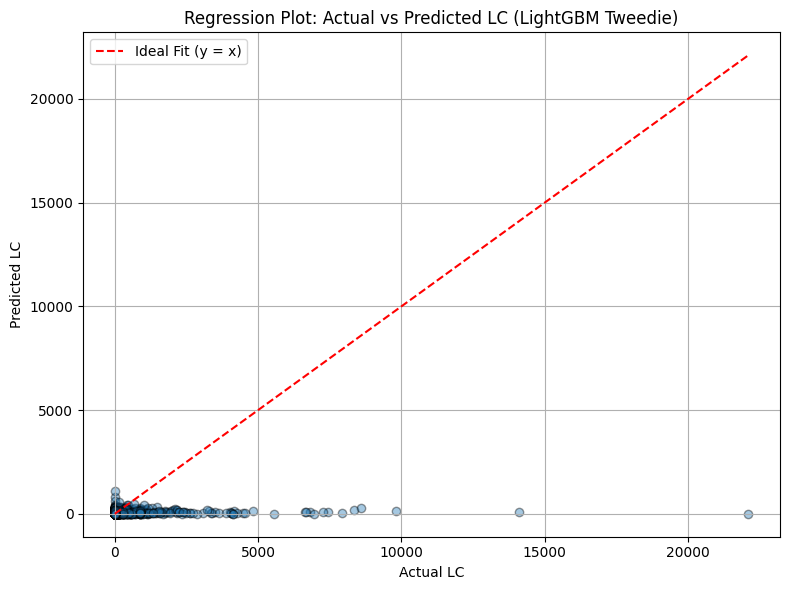

In [ ]:

# ----------------------------
# LightGBM Regressor with Tweedie
# ----------------------------
reg_model = LGBMRegressor(
    objective='tweedie',
    tweedie_variance_power=1.5,
    learning_rate=0.05,
    n_estimators=300,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
reg_model.fit(X_train_trans, y_train)

# Predict on test set
y_pred = reg_model.predict(X_test_trans)

# MSE evaluation
mse = mean_squared_error(y_test, y_pred)
print("MSE on Test Set (LightGBM Tweedie):", mse)

# ----------------------------
# Regression Plot
# ----------------------------
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.4, edgecolor='k')
plt.plot([0, max(y_test.max(), y_pred.max())],
         [0, max(y_test.max(), y_pred.max())],
         'r--', label='Ideal Fit (y = x)')
plt.xlabel("Actual LC")
plt.ylabel("Predicted LC")
plt.title("Regression Plot: Actual vs Predicted LC (LightGBM Tweedie)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1565
[LightGBM] [Info] Number of data points in the train set: 36858, number of used features: 34
[LightGBM] [Info] Start training from score 4.258922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best Parameters: {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 4, 'regressor__n_estimators': 100, 'regressor__reg_alpha': 1.0, 'regressor__subsample': 0.8, 'regressor__tweedie_variance_power': 1.5}
MSE (CV Tuned Model): 703485.8314027898


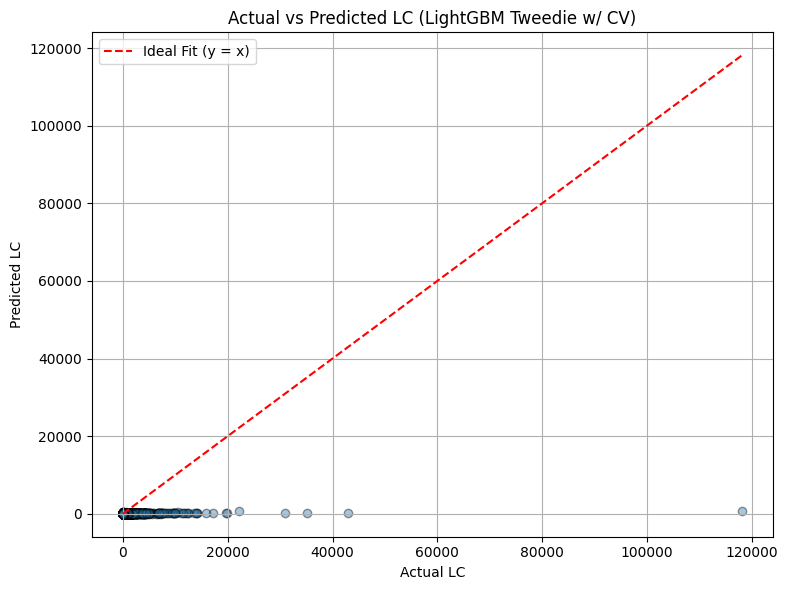

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

# Load data
df = pd.read_csv("/content/drive/My Drive/DSO530 Final Project/insurance_train.csv")

# Compute LC
df['LC'] = df.apply(lambda row: row['X.15'] / row['X.16'] if row['X.16'] > 0 else 0, axis=1)

# Dates → derived features
today = pd.to_datetime('2025-04-23')
for col in ['X.2', 'X.5', 'X.6']:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
df['age'] = (today - df['X.5']).dt.days // 365
df['license_years'] = (today - df['X.6']).dt.days // 365
df['policy_years'] = (today - df['X.2']).dt.days // 365

# Feature set
features = [
    'X.7', 'X.8', 'X.9', 'X.10', 'X.11', 'X.12', 'X.13',
    'X.14', 'X.19', 'X.20', 'X.21', 'X.22', 'X.23', 'X.24',
    'X.25', 'X.26', 'X.27', 'X.28', 'age', 'license_years', 'policy_years'
]

# Drop rows with missing values
df.dropna(subset=features, inplace=True)

# Define X and y
X = df[features]
y = df['LC']

# Categorical and numeric columns
categorical_cols = ['X.7', 'X.13', 'X.19', 'X.20', 'X.21', 'X.26', 'X.27']
numeric_cols = [col for col in features if col not in categorical_cols]

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# LightGBM base model
lgb_model = LGBMRegressor(objective='tweedie', random_state=42)

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', lgb_model)
])

# Parameter grid
param_grid = {
    'regressor__learning_rate': [0.01, 0.05],
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [4, 6],
    'regressor__subsample': [0.8],
    'regressor__colsample_bytree': [0.8],
    'regressor__reg_alpha': [0.01, 0.1, 0.5, 1.0],
    'regressor__tweedie_variance_power': [1.0, 1.5, 1.9]
}

# GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X, y)

# Best model and results
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)
mse = mean_squared_error(y, y_pred)

# Output
print("Best Parameters:", grid_search.best_params_)
print("MSE (CV Tuned Model):", mse)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, alpha=0.4, edgecolor='k')
plt.plot([0, max(y.max(), y_pred.max())], [0, max(y.max(), y_pred.max())],
         'r--', label='Ideal Fit (y = x)')
plt.xlabel("Actual LC")
plt.ylabel("Predicted LC")
plt.title("Actual vs Predicted LC (LightGBM Tweedie w/ CV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# LightGBM CV

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1565
[LightGBM] [Info] Number of data points in the train set: 36858, number of used features: 34
[LightGBM] [Info] Start training from score 4.258922


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best Parameters: {'regressor__reg_alpha': 0.01, 'regressor__tweedie_variance_power': 1.5}
MSE (CV Tuned Model): 549966.3987065672


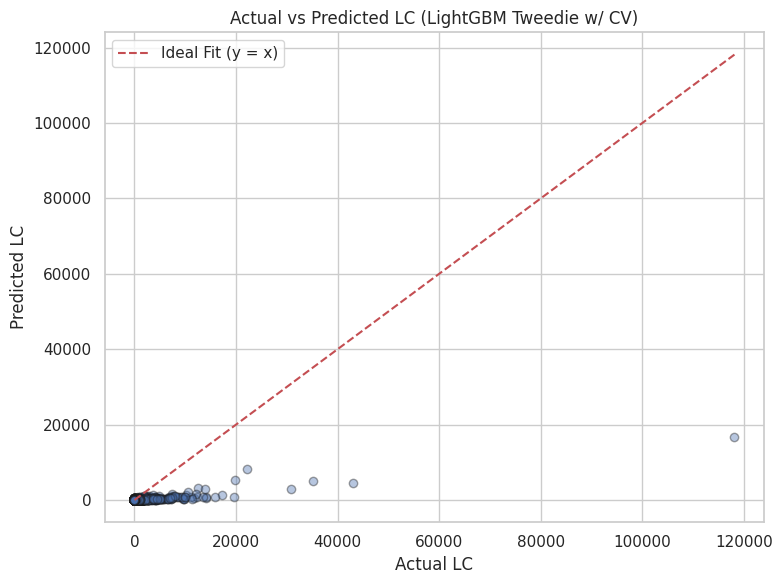

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

# Load data
df = pd.read_csv("/content/drive/My Drive/DSO530 Final Project/insurance_train.csv")

# Compute LC
df['LC'] = df.apply(lambda row: row['X.15'] / row['X.16'] if row['X.16'] > 0 else 0, axis=1)

# Dates → derived features
today = pd.to_datetime('2025-04-23')
for col in ['X.2', 'X.5', 'X.6']:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
df['age'] = (today - df['X.5']).dt.days // 365
df['license_years'] = (today - df['X.6']).dt.days // 365
df['policy_years'] = (today - df['X.2']).dt.days // 365

# Feature set
features = [
    'X.7', 'X.8', 'X.9', 'X.10', 'X.11', 'X.12', 'X.13',
    'X.14', 'X.19', 'X.20', 'X.21', 'X.22', 'X.23', 'X.24',
    'X.25', 'X.26', 'X.27', 'X.28', 'age', 'license_years', 'policy_years'
]

# Drop rows with missing values
df.dropna(subset=features, inplace=True)

# Define X and y
X = df[features]
y = df['LC']

# Categorical and numeric columns
categorical_cols = ['X.7', 'X.13', 'X.19', 'X.20', 'X.21', 'X.26', 'X.27']
numeric_cols = [col for col in features if col not in categorical_cols]

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# LightGBM base model
lgb_model = LGBMRegressor(objective='tweedie', random_state=42)

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', lgb_model)
])

# Parameter grid
param_grid = {
    'regressor__reg_alpha': [0.01, 0.1, 0.5, 1.0],
    'regressor__tweedie_variance_power': [1.0, 1.5, 1.9]
}

# GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X, y)

# Best model and results
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)
mse = mean_squared_error(y, y_pred)

# Output
print("Best Parameters:", grid_search.best_params_)
print("MSE (CV Tuned Model):", mse)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, alpha=0.4, edgecolor='k')
plt.plot([0, max(y.max(), y_pred.max())], [0, max(y.max(), y_pred.max())],
         'r--', label='Ideal Fit (y = x)')
plt.xlabel("Actual LC")
plt.ylabel("Predicted LC")
plt.title("Actual vs Predicted LC (LightGBM Tweedie w/ CV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


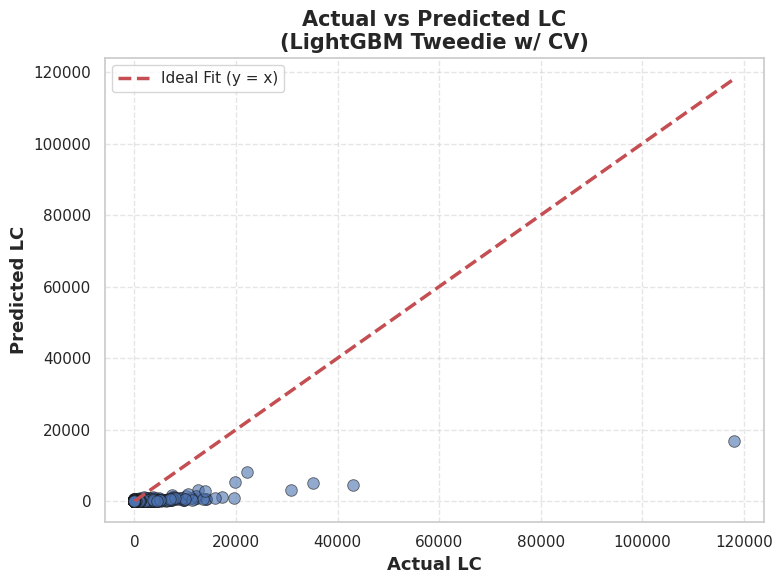

In [ ]:
import seaborn as sns

# Enhanced Scatter Plot
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

# Plot scatter
sns.scatterplot(x=y, y=y_pred, alpha=0.6, s=70, edgecolor='k')

# Ideal line
max_val = max(y.max(), y_pred.max())
plt.plot([0, max_val], [0, max_val], 'r--', linewidth=2.5, label='Ideal Fit (y = x)')

# Labeling
plt.xlabel("Actual LC", fontsize=13, weight='bold')
plt.ylabel("Predicted LC", fontsize=13, weight='bold')
plt.title("Actual vs Predicted LC\n(LightGBM Tweedie w/ CV)", fontsize=15, weight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# XGBoost CV - HALC

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **las

Best Parameters: {'regressor__reg_alpha': 0.01, 'regressor__tweedie_variance_power': 1.5}
MSE (CV Tuned Model): 653948.3337552559


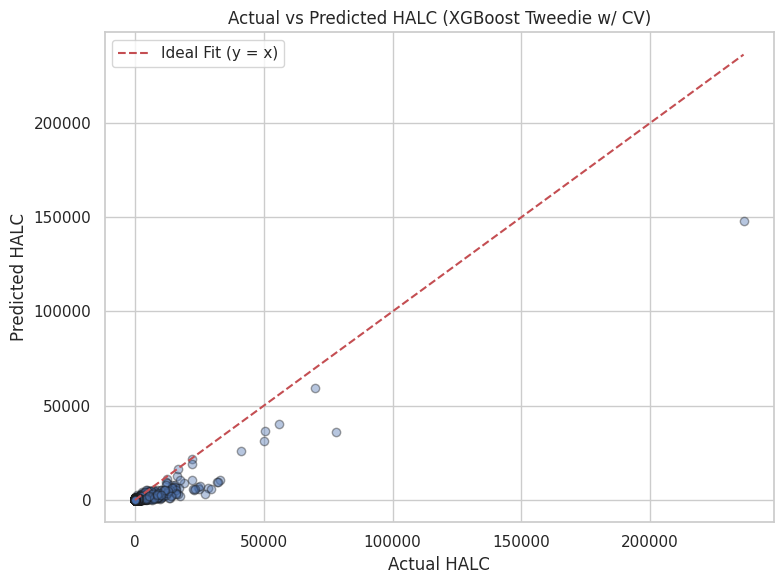

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# Load data
df = pd.read_csv("/content/drive/My Drive/DSO530 Final Project/insurance_train.csv")

# Compute HALC = (X.15 / X.16) * X.18
df['HALC'] = df.apply(lambda row: (row['X.15'] / row['X.16']) * row['X.18'] if row['X.16'] > 0 else 0, axis=1)

# Dates → derived features
today = pd.to_datetime('2025-04-23')
for col in ['X.2', 'X.5', 'X.6']:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
df['age'] = (today - df['X.5']).dt.days // 365
df['license_years'] = (today - df['X.6']).dt.days // 365
df['policy_years'] = (today - df['X.2']).dt.days // 365

# Feature set
features = [
    'X.7', 'X.8', 'X.9', 'X.10', 'X.11', 'X.12', 'X.13',
    'X.14', 'X.19', 'X.20', 'X.21', 'X.22', 'X.23', 'X.24',
    'X.25', 'X.26', 'X.27', 'X.28', 'age', 'license_years', 'policy_years'
]

# Drop rows with missing values
df.dropna(subset=features + ['HALC'], inplace=True)

# Define X and y
X = df[features]
y = df['HALC']

# Categorical and numeric columns
categorical_cols = ['X.7', 'X.13', 'X.19', 'X.20', 'X.21', 'X.27']
numeric_cols = [col for col in features if col not in categorical_cols]

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# XGBoost Regressor
xgb_model = XGBRegressor(
    objective='reg:tweedie',
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])

# Parameter grid
param_grid = {
    'regressor__reg_alpha': [0.01, 0.1, 0.5, 1.0],
    'regressor__tweedie_variance_power': [1.0, 1.5, 1.9]
}

# GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X, y)

# Best model and results
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)
mse = mean_squared_error(y, y_pred)

# Output
print("Best Parameters:", grid_search.best_params_)
print("MSE (CV Tuned Model):", mse)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, alpha=0.4, edgecolor='k')
plt.plot([0, max(y.max(), y_pred.max())], [0, max(y.max(), y_pred.max())],
         'r--', label='Ideal Fit (y = x)')
plt.xlabel("Actual HALC")
plt.ylabel("Predicted HALC")
plt.title("Actual vs Predicted HALC (XGBoost Tweedie w/ CV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


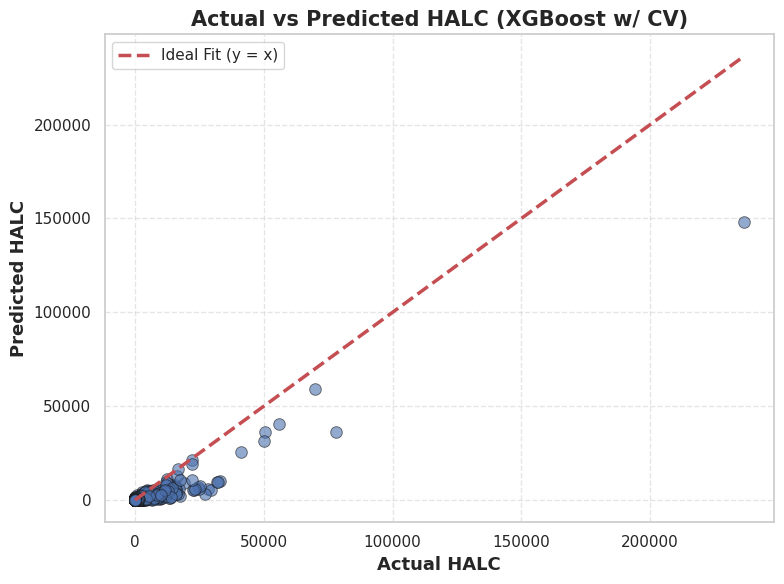

In [ ]:
import seaborn as sns

# Enhanced Scatter Plot
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

# Plot scatter
sns.scatterplot(x=y, y=y_pred, alpha=0.6, s=70, edgecolor='k')

# Ideal line
max_val = max(y.max(), y_pred.max())
plt.plot([0, max_val], [0, max_val], 'r--', linewidth=2.5, label='Ideal Fit (y = x)')

# Labeling
plt.xlabel("Actual HALC", fontsize=13, weight='bold')
plt.ylabel("Predicted HALC", fontsize=13, weight='bold')
plt.title("Actual vs Predicted HALC (XGBoost w/ CV)", fontsize=15, weight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Correlation of features with X.18:
X.18             1.000000
X.16             0.539461
X.17             0.350167
X.14             0.178168
X.13             0.146919
X.15             0.142745
X.12             0.113374
X.24             0.109510
X.28             0.090634
X.23             0.090362
X.26             0.082486
X.25             0.079650
X.9              0.066300
X.10             0.065681
X.19             0.060828
X.7              0.056149
X.20             0.049816
X.21             0.036459
X.1              0.026503
X.22            -0.005090
X.11            -0.018542
age             -0.058735
policy_years    -0.068128
license_years   -0.077259
X.8             -0.082233
Name: X.18, dtype: float64


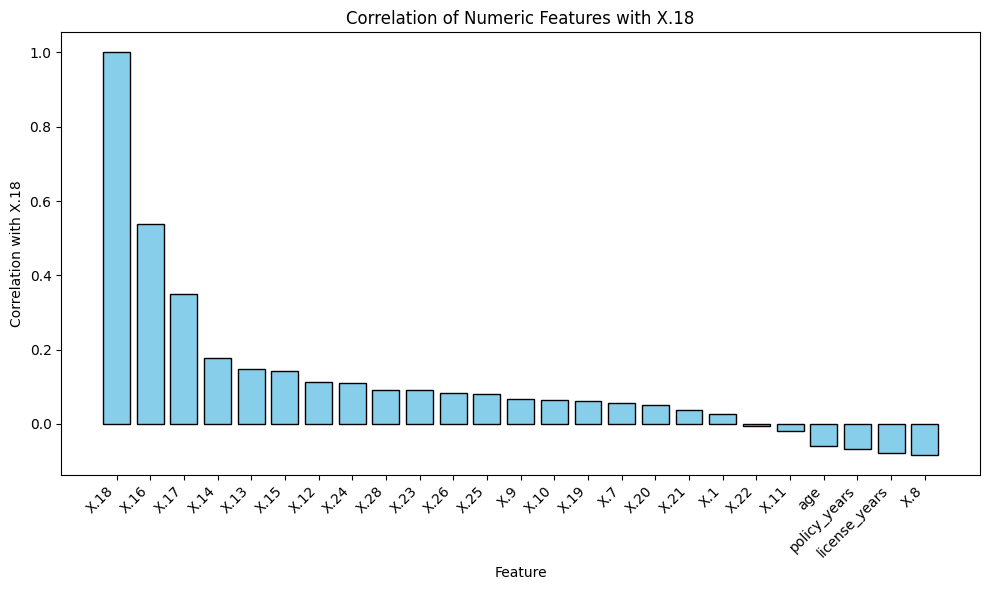

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming the DataFrame 'df' has been loaded as in your earlier code:
# df = pd.read_csv(".../insurance_train.csv")

# (Re)load and prepare the data if necessary
df = pd.read_csv("/content/drive/My Drive/DSO530 Final Project/insurance_train.csv")

# Convert date columns (if not already done)
today = pd.to_datetime('2025-04-23')
for col in ['X.2', 'X.5', 'X.6']:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')

# Compute derived features as before
df['age'] = (today - df['X.5']).dt.days // 365
df['license_years'] = (today - df['X.6']).dt.days // 365
df['policy_years'] = (today - df['X.2']).dt.days // 365

# Selecting only numeric columns for correlation analysis
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Compute the correlation matrix and extract correlations with X.18
corr_matrix = df[numeric_cols].corr()
x18_corr = corr_matrix['X.18'].sort_values(ascending=False)
print("Correlation of features with X.18:")
print(x18_corr)

# Visualize the correlations with X.18 using a bar chart
plt.figure(figsize=(10,6))
plt.bar(x18_corr.index, x18_corr.values, color='skyblue', edgecolor='k')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Feature")
plt.ylabel("Correlation with X.18")
plt.title("Correlation of Numeric Features with X.18")
plt.tight_layout()
plt.show()


# LGBM HALC

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1560
[LightGBM] [Info] Number of data points in the train set: 36858, number of used features: 29
[LightGBM] [Info] Start training from score 4.866702


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best Parameters: {'regressor__reg_alpha': 0.5, 'regressor__tweedie_variance_power': 1.1}
MSE (CV Tuned Model): 360881.60433959396


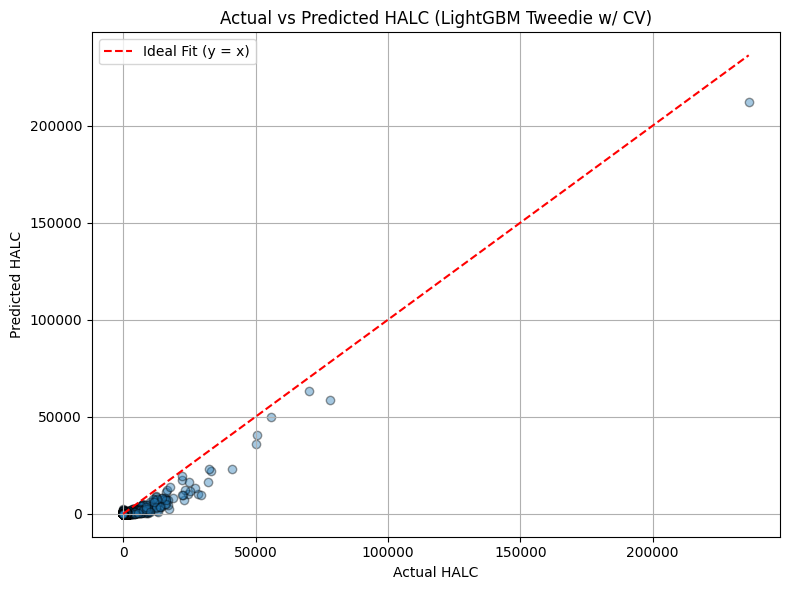

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

# Load data
df = pd.read_csv("/content/drive/My Drive/DSO530 Final Project/insurance_train.csv")

# Compute HALC = (X.15 / X.16) * X.18
df['HALC'] = df.apply(lambda row: (row['X.15'] / row['X.16']) * row['X.18'] if row['X.16'] > 0 else 0, axis=1)

# Dates → derived features
today = pd.to_datetime('2025-04-23')
for col in ['X.2', 'X.5', 'X.6']:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
df['age'] = (today - df['X.5']).dt.days // 365
df['license_years'] = (today - df['X.6']).dt.days // 365
df['policy_years'] = (today - df['X.2']).dt.days // 365

# Feature set
features = [
    'X.7', 'X.8', 'X.9', 'X.10', 'X.11', 'X.12', 'X.13',
    'X.14', 'X.19', 'X.20', 'X.21', 'X.22', 'X.23', 'X.24',
    'X.25', 'X.26', 'X.27', 'X.28', 'age', 'license_years', 'policy_years'
]

# Drop rows with missing values
df.dropna(subset=features + ['HALC'], inplace=True)

# Define X and y
X = df[features]
y = df['HALC']

# Categorical and numeric columns
categorical_cols = ['X.7', 'X.13', 'X.19', 'X.20', 'X.21', 'X.27']
numeric_cols = [col for col in features if col not in categorical_cols]

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# LightGBM Regressor
lgbm_model = LGBMRegressor(
    objective='tweedie',
    random_state=42,
    n_jobs=-1
)

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', lgbm_model)
])

# Parameter grid
param_grid = {
    'regressor__reg_alpha': [0.01, 0.1, 0.5],
    'regressor__tweedie_variance_power': [1.1, 1.5, 1.9]
}

# GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X, y)

# Best model and results
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)
mse = mean_squared_error(y, y_pred)

# Output
print("Best Parameters:", grid_search.best_params_)
print("MSE (CV Tuned Model):", mse)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, alpha=0.4, edgecolor='k')
plt.plot([0, max(y.max(), y_pred.max())], [0, max(y.max(), y_pred.max())],
         'r--', label='Ideal Fit (y = x)')
plt.xlabel("Actual HALC")
plt.ylabel("Predicted HALC")
plt.title("Actual vs Predicted HALC (LightGBM Tweedie w/ CV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


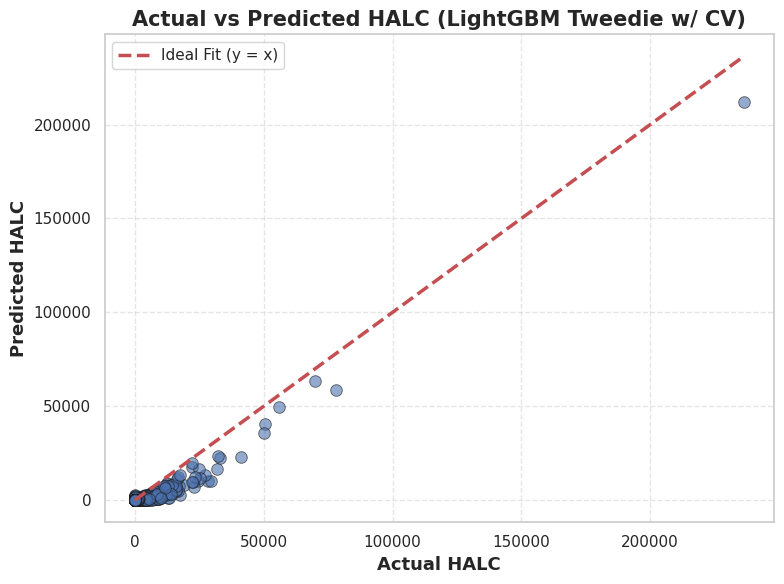

In [ ]:
import seaborn as sns

# Enhanced Scatter Plot
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

# Plot scatter
sns.scatterplot(x=y, y=y_pred, alpha=0.6, s=70, edgecolor='k')

# Ideal line
max_val = max(y.max(), y_pred.max())
plt.plot([0, max_val], [0, max_val], 'r--', linewidth=2.5, label='Ideal Fit (y = x)')

# Labeling
plt.xlabel("Actual HALC", fontsize=13, weight='bold')
plt.ylabel("Predicted HALC", fontsize=13, weight='bold')
plt.title("Actual vs Predicted HALC (LightGBM Tweedie w/ CV)", fontsize=15, weight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Try Meta Ensemble

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


MSE (Stacking Ensemble): 414808.38256923686


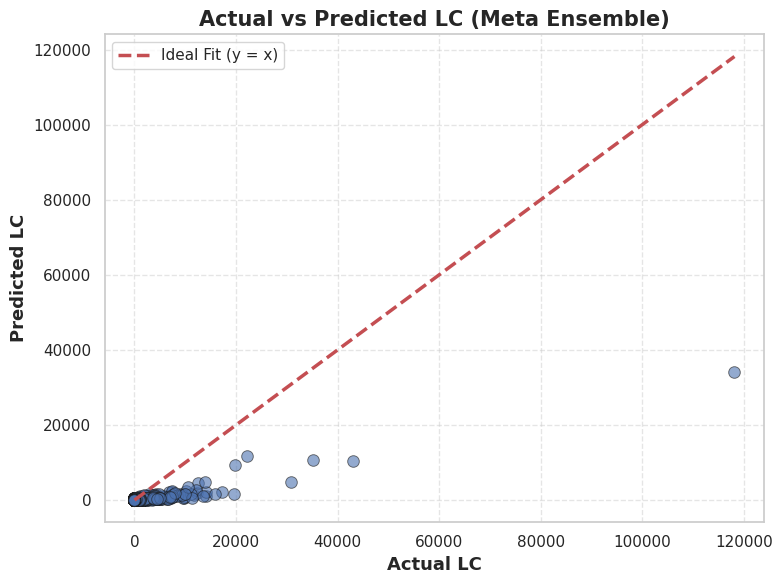

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import TweedieRegressor, Ridge
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Load data
df = pd.read_csv("/content/drive/My Drive/DSO530 Final Project/insurance_train.csv")

# Compute LC
df['LC'] = df.apply(lambda row: row['X.15'] / row['X.16'] if row['X.16'] > 0 else 0, axis=1)

# Convert dates and create derived features
today = pd.to_datetime('2025-04-23')
for col in ['X.2', 'X.5', 'X.6']:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')

df['age'] = (today - df['X.5']).dt.days // 365
df['license_years'] = (today - df['X.6']).dt.days // 365
df['policy_years'] = (today - df['X.2']).dt.days // 365

# Define features
features = [
    'X.7', 'X.8', 'X.9', 'X.10', 'X.11', 'X.12', 'X.13',
    'X.14', 'X.19', 'X.20', 'X.21', 'X.22', 'X.23', 'X.24',
    'X.25', 'X.26', 'X.27', 'X.28', 'age', 'license_years', 'policy_years'
]

# Drop missing
df.dropna(subset=features, inplace=True)

# Define X and y
X = df[features]
y = df['LC']

# Categorical and numeric columns
categorical_cols = ['X.7', 'X.13', 'X.19', 'X.20', 'X.21', 'X.26', 'X.27']
numeric_cols = [col for col in features if col not in categorical_cols]

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Define base models
lgb_model = LGBMRegressor(objective='tweedie', random_state=42)
xgb_model = XGBRegressor(objective='reg:tweedie', random_state=42, verbosity=0)
tweedie_model = TweedieRegressor(power=1.5, alpha=0.1, max_iter=1000)

# Wrap each model in a pipeline
lgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', lgb_model)
])

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])

tweedie_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', tweedie_model)
])

# Meta learner
meta_learner = Ridge(alpha=1.0)

# Stacking Regressor
stack_model = StackingRegressor(
    estimators=[
        ('lgb', lgb_pipeline),
        ('xgb', xgb_pipeline),
        ('tweedie', tweedie_pipeline)
    ],
    final_estimator=meta_learner,
    passthrough=False,  # important: do not include raw X
    cv=5,
    n_jobs=-1
)

# Fit ensemble
stack_model.fit(X, y)

# Predict and evaluate
y_pred = stack_model.predict(X)
mse = mean_squared_error(y, y_pred)
print("MSE (Stacking Ensemble):", mse)

# Plot results
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
sns.scatterplot(x=y, y=y_pred, alpha=0.6, s=70, edgecolor='k')
max_val = max(y.max(), y_pred.max())
plt.plot([0, max_val], [0, max_val], 'r--', linewidth=2.5, label='Ideal Fit (y = x)')
plt.xlabel("Actual LC", fontsize=13, weight='bold')
plt.ylabel("Predicted LC", fontsize=13, weight='bold')
plt.title("Actual vs Predicted LC (Meta Ensemble)", fontsize=15, weight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# XGBoost CV - LC 217K


Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [-3.26756437e+35 -7.15808121e+05             nan -3.26756437e+35
 -7.15497113e+05             nan -3.26756437e+35 -7.16128692e+05
             nan -3.26756437e+35 -7.15392638e+05             nan]
  warnings.warn(


Best Parameters: {'regressor__reg_alpha': 1.0, 'regressor__tweedie_variance_power': 1.5}
MSE (CV Tuned Model): 217392.02249079116


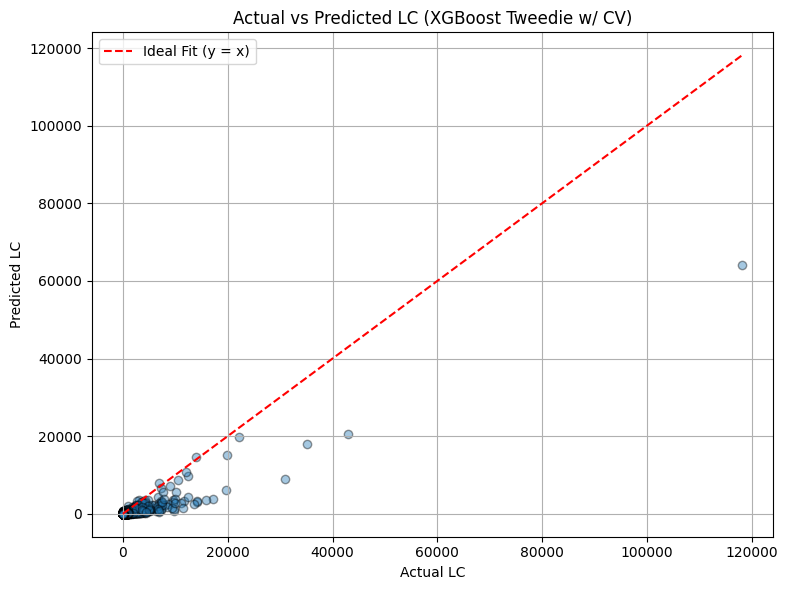

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# Load data
df = pd.read_csv("/content/drive/My Drive/DSO530 Final Project/insurance_train.csv")

# Compute LC
df['LC'] = df.apply(lambda row: row['X.15'] / row['X.16'] if row['X.16'] > 0 else 0, axis=1)

# Dates → derived features
today = pd.to_datetime('2025-04-23')
for col in ['X.2', 'X.5', 'X.6']:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
df['age'] = (today - df['X.5']).dt.days // 365
df['license_years'] = (today - df['X.6']).dt.days // 365
df['policy_years'] = (today - df['X.2']).dt.days // 365

# Feature set
features = [
    'X.7', 'X.8', 'X.9', 'X.10', 'X.11', 'X.12', 'X.13',
    'X.14', 'X.19', 'X.20', 'X.21', 'X.22', 'X.23', 'X.24',
    'X.25', 'X.26', 'X.27', 'X.28', 'age', 'license_years', 'policy_years'
]

# Drop rows with missing values
df.dropna(subset=features, inplace=True)

# Define X and y
X = df[features]
y = df['LC']

# Categorical and numeric columns
categorical_cols = ['X.7', 'X.13', 'X.19', 'X.20', 'X.21', 'X.27']
numeric_cols = [col for col in features if col not in categorical_cols]

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# XGBoost Regressor
xgb_model = XGBRegressor(
    objective='reg:tweedie',
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])

# Parameter grid
param_grid = {
    'regressor__reg_alpha': [0.01, 0.1, 0.5, 1.0],
    'regressor__tweedie_variance_power': [1.0, 1.5, 1.9]
}

# GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X, y)

# Best model and results
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)
mse = mean_squared_error(y, y_pred)

# Output
print("Best Parameters:", grid_search.best_params_)
print("MSE (CV Tuned Model):", mse)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, alpha=0.4, edgecolor='k')
plt.plot([0, max(y.max(), y_pred.max())], [0, max(y.max(), y_pred.max())],
         'r--', label='Ideal Fit (y = x)')
plt.xlabel("Actual LC")
plt.ylabel("Predicted LC")
plt.title("Actual vs Predicted LC (XGBoost Tweedie w/ CV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# prompt: what's the percentage of 0s in column x.16

df = pd.read_csv("/content/drive/My Drive/DSO530 Final Project/insurance_train.csv")

# Calculate the percentage of 0s in column 'X.16'
percentage_zeros = (df['X.16'] == 0).sum() / len(df) * 100

print(f"The percentage of 0s in column 'X.16' is: {percentage_zeros:.2f}%")


The percentage of 0s in column 'X.16' is: 88.92%


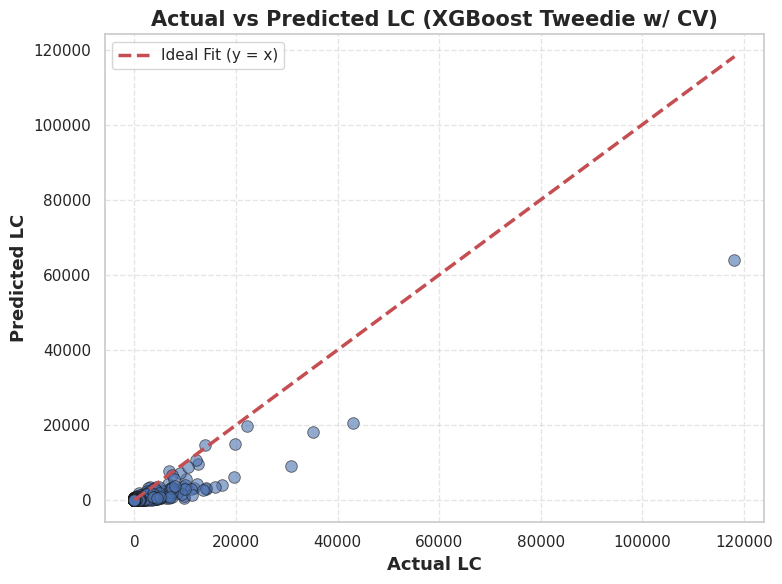

In [ ]:
import seaborn as sns

# Enhanced Scatter Plot
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

# Plot scatter
sns.scatterplot(x=y, y=y_pred, alpha=0.6, s=70, edgecolor='k')

# Ideal line
max_val = max(y.max(), y_pred.max())
plt.plot([0, max_val], [0, max_val], 'r--', linewidth=2.5, label='Ideal Fit (y = x)')

# Labeling
plt.xlabel("Actual LC", fontsize=13, weight='bold')
plt.ylabel("Predicted LC", fontsize=13, weight='bold')
plt.title("Actual vs Predicted LC (XGBoost Tweedie w/ CV)", fontsize=15, weight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Tweedie Regressor CV - LC

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'regressor__alpha': 1.0, 'regressor__power': 1.9}
MSE (CV Tuned Model): 713094.2229144331


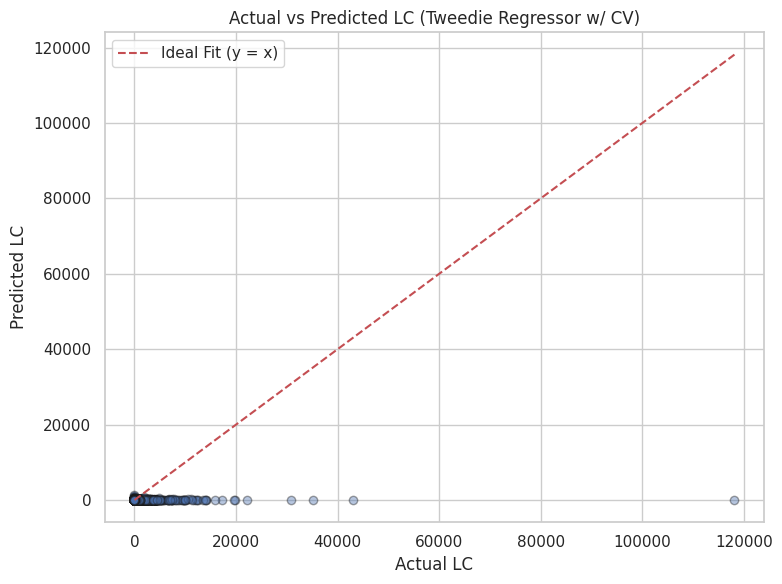

In [ ]:
from sklearn.linear_model import TweedieRegressor

# Tweedie Regressor
tweedie_model = TweedieRegressor(
    power=1.5,       # Default, will be tuned
    alpha=0.1,       # Regularization strength
    max_iter=1000
)

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', tweedie_model)
])

# Parameter grid
param_grid = {
    'regressor__alpha': [0.01, 0.1, 0.5, 1.0],
    'regressor__power': [1.0, 1.5, 1.9]
}

# GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X, y)

# Best model and results
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)
mse = mean_squared_error(y, y_pred)

# Output
print("Best Parameters:", grid_search.best_params_)
print("MSE (CV Tuned Model):", mse)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, alpha=0.4, edgecolor='k')
plt.plot([0, max(y.max(), y_pred.max())], [0, max(y.max(), y_pred.max())],
         'r--', label='Ideal Fit (y = x)')
plt.xlabel("Actual LC")
plt.ylabel("Predicted LC")
plt.title("Actual vs Predicted LC (Tweedie Regressor w/ CV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


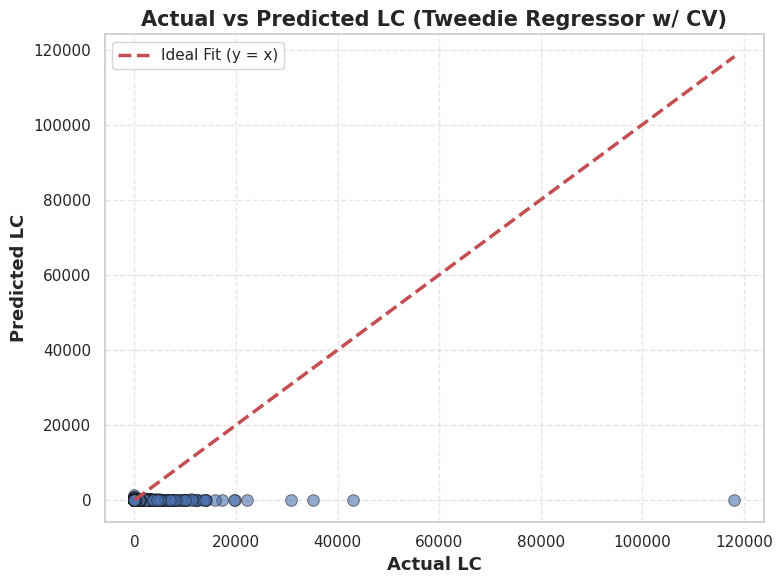

In [ ]:
import seaborn as sns

# Enhanced Scatter Plot
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

# Plot scatter
sns.scatterplot(x=y, y=y_pred, alpha=0.6, s=70, edgecolor='k')

# Ideal line
max_val = max(y.max(), y_pred.max())
plt.plot([0, max_val], [0, max_val], 'r--', linewidth=2.5, label='Ideal Fit (y = x)')

# Labeling
plt.xlabel("Actual LC", fontsize=13, weight='bold')
plt.ylabel("Predicted LC", fontsize=13, weight='bold')
plt.title("Actual vs Predicted LC (Tweedie Regressor w/ CV)", fontsize=15, weight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [-3.26756437e+35 -7.15838077e+05             nan -3.26756437e+35
 -7.15947354e+05             nan -3.26756437e+35 -7.15897467e+05
             nan -3.26756437e+35 -7.15708149e+05             nan]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:188: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Best Parameters: {'regressor__reg_alpha': 1.0, 'regressor__tweedie_variance_power': 1.5}
MSE (CV Tuned Model): 274508.8233822072


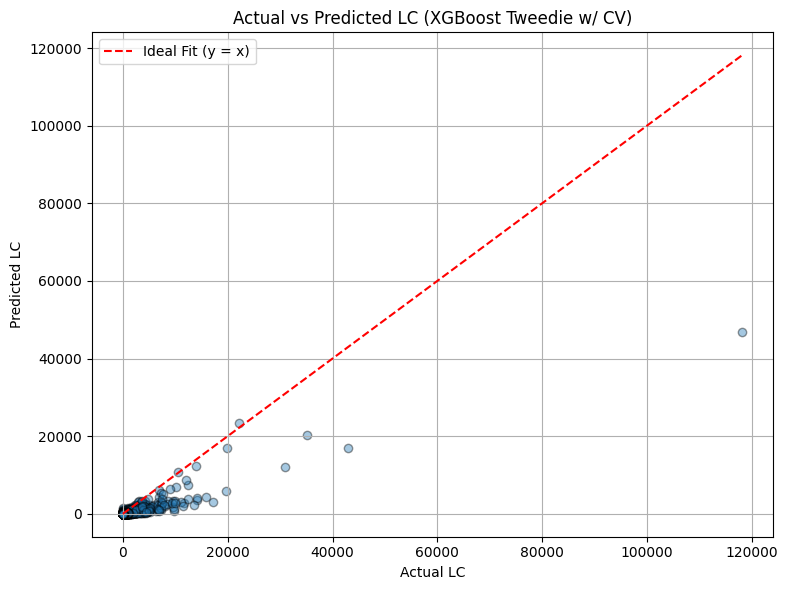

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# Load data
df = pd.read_csv("/content/drive/My Drive/DSO530 Final Project/insurance_train.csv")

# Compute LC
df['LC'] = df.apply(lambda row: row['X.15'] / row['X.16'] if row['X.16'] > 0 else 0, axis=1)

# Dates → derived features
today = pd.to_datetime('2025-04-23')
for col in ['X.2', 'X.5', 'X.6']:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
df['age'] = (today - df['X.5']).dt.days // 365
df['license_years'] = (today - df['X.6']).dt.days // 365
df['policy_years'] = (today - df['X.2']).dt.days // 365

# Feature set
features = [
    'X.7', 'X.8', 'X.9', 'X.10', 'X.11', 'X.12', 'X.13',
    'X.14', 'X.19', 'X.20', 'X.21', 'X.22', 'X.23', 'X.24',
    'X.25', 'X.26', 'X.27', 'X.28', 'age', 'license_years', 'policy_years'
]

# Drop rows with missing values
df.dropna(subset=features, inplace=True)

# Define X and y
X = df[features]
y = df['LC']

# Categorical and numeric columns
categorical_cols = ['X.7', 'X.13', 'X.19', 'X.20', 'X.21', 'X.27']
numeric_cols = [col for col in features if col not in categorical_cols]

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

preprocessor_power = ColumnTransformer([
    ('num', PowerTransformer(), numeric_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
])

# XGBoost Regressor
xgb_model = XGBRegressor(
    objective='reg:tweedie',
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor_power),
    ('regressor', xgb_model)
])

# Parameter grid
param_grid = {
    'regressor__reg_alpha': [0.01, 0.1, 0.5, 1.0],
    'regressor__tweedie_variance_power': [1.0, 1.5, 1.9]
}

# GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X, y)

# Best model and results
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)
mse = mean_squared_error(y, y_pred)

# Output
print("Best Parameters:", grid_search.best_params_)
print("MSE (CV Tuned Model):", mse)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, alpha=0.4, edgecolor='k')
plt.plot([0, max(y.max(), y_pred.max())], [0, max(y.max(), y_pred.max())],
         'r--', label='Ideal Fit (y = x)')
plt.xlabel("Actual LC")
plt.ylabel("Predicted LC")
plt.title("Actual vs Predicted LC (XGBoost Tweedie w/ CV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:


# XGBoost Regressor
xgb_model = XGBRegressor(
    objective='reg:tweedie',
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Pipeline
pipeline = Pipeline([
    ('regressor', xgb_model)
])

# Parameter grid
param_grid = {
    'regressor__reg_alpha': [0.01, 0.1, 0.5, 1.0],
    'regressor__tweedie_variance_power': [1.0, 1.5, 1.9]
}

# GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_transformed_selected, y)

# Best model and results
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_transformed_selected)
mse = mean_squared_error(y, y_pred)

# Output
print("Best Parameters:", grid_search.best_params_)
print("MSE (CV Tuned Model):", mse)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, alpha=0.4, edgecolor='k')
plt.plot([0, max(y.max(), y_pred.max())], [0, max(y.max(), y_pred.max())],
         'r--', label='Ideal Fit (y = x)')
plt.xlabel("Actual LC")
plt.ylabel("Predicted LC")
plt.title("Actual vs Predicted LC (XGBoost Tweedie w/ CV) using feature selection")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'XGBRegressor' is not defined

MSE on Test Set (XGBoost Tweedie): 248074.6777692037


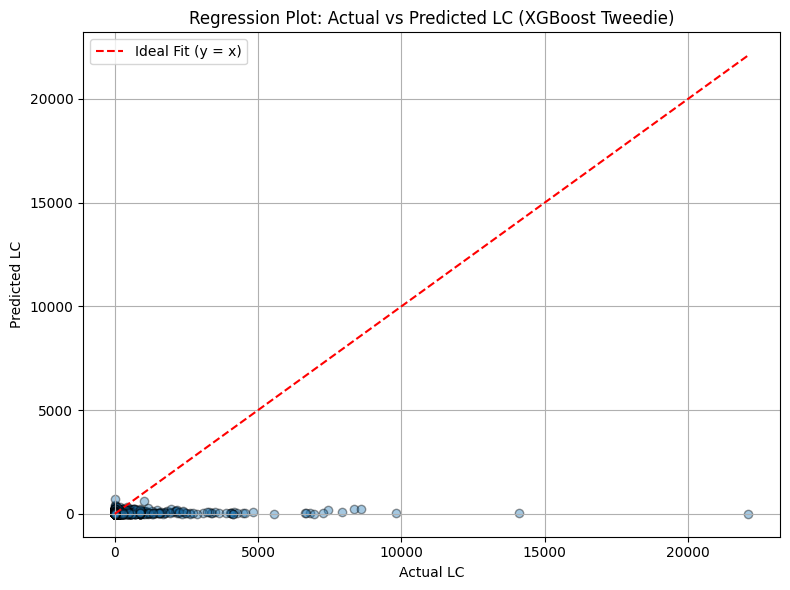

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Load data
df = pd.read_csv("/content/drive/My Drive/DSO530 Final Project/insurance_train.csv")

# Compute LC
df['LC'] = df.apply(lambda row: row['X.15'] / row['X.16'] if row['X.16'] > 0 else 0, axis=1)

# Dates → derived features
for col in ['X.2', 'X.5', 'X.6']:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
df['age'] = (pd.to_datetime('2025-04-16') - df['X.5']).dt.days // 365
df['license_years'] = (pd.to_datetime('2025-04-16') - df['X.6']).dt.days // 365
df['policy_years'] = (pd.to_datetime('2025-04-16') - df['X.2']).dt.days // 365

# Feature set
features = [
    'X.7', 'X.8', 'X.9', 'X.10', 'X.11', 'X.12', 'X.13',
    'X.14', 'X.19', 'X.20', 'X.21', 'X.22', 'X.23', 'X.24',
    'X.25', 'X.26', 'X.27', 'X.28', 'age', 'license_years', 'policy_years'
]

# Drop rows with missing values
df.dropna(subset=features, inplace=True)

# Define X and y
X = df[features]
y = df['LC']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
categorical_cols = ['X.7', 'X.13', 'X.19', 'X.20', 'X.21', 'X.26', 'X.27']
numeric_cols = [col for col in features if col not in categorical_cols]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Fit and transform
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

# ----------------------------
# XGBoost Regressor with Tweedie
# ----------------------------
xgb_model = xgb.XGBRegressor(
    objective='reg:tweedie',
    tweedie_variance_power=1.5,
    learning_rate=0.05,
    n_estimators=300,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train_trans, y_train)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test_trans)

# MSE evaluation
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print("MSE on Test Set (XGBoost Tweedie):", mse_xgb)

# ----------------------------
# Regression Plot
# ----------------------------
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.4, edgecolor='k')
plt.plot([0, max(y_test.max(), y_pred_xgb.max())],
         [0, max(y_test.max(), y_pred_xgb.max())],
         'r--', label='Ideal Fit (y = x)')
plt.xlabel("Actual LC")
plt.ylabel("Predicted LC")
plt.title("Regression Plot: Actual vs Predicted LC (XGBoost Tweedie)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Apply log transformation
y_train_log = np.log1p(y_train)  # log(1 + LC) to handle zeros
y_test_log = np.log1p(y_test)

# Fit XGBoost on log-transformed target
xgb_model.fit(X_train_trans, y_train_log)

# Predict in log scale, then convert back
y_pred_log = xgb_model.predict(X_test_trans)
y_pred = np.expm1(y_pred_log)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
print("MSE with log-transformed target:", mse)


MSE with log-transformed target: 253072.93101889867


Fitting 3 folds for each of 24 candidates, totalling 72 fits
MSE with GridSearchCV Best Model: 253051.2389195933
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500, 'subsample': 0.8, 'tweedie_variance_power': 1.3}


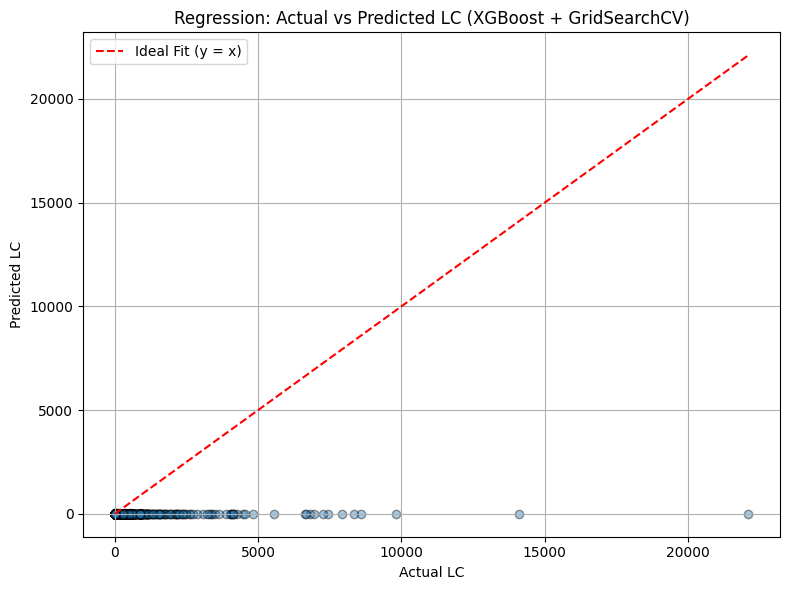

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# ----------------------------
# Load & Preprocess Data
# ----------------------------
df = pd.read_csv("/content/drive/My Drive/DSO530 Final Project/insurance_train.csv")
df['LC'] = df.apply(lambda row: row['X.15'] / row['X.16'] if row['X.16'] > 0 else 0, axis=1)

for col in ['X.2', 'X.5', 'X.6']:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
df['age'] = (pd.to_datetime('2025-04-16') - df['X.5']).dt.days // 365
df['license_years'] = (pd.to_datetime('2025-04-16') - df['X.6']).dt.days // 365
df['policy_years'] = (pd.to_datetime('2025-04-16') - df['X.2']).dt.days // 365

features = [
    'X.7', 'X.8', 'X.9', 'X.10', 'X.11', 'X.12', 'X.13',
    'X.14', 'X.19', 'X.20', 'X.21', 'X.22', 'X.23', 'X.24',
    'X.25', 'X.26', 'X.27', 'X.28', 'age', 'license_years', 'policy_years'
]
df.dropna(subset=features, inplace=True)

X = df[features]
y = df['LC']

# Optional: cap extreme outliers in LC
# cap = y.quantile(0.99)
# y = np.where(y > cap, cap, y)

# ----------------------------
# Split & Transform Features
# ----------------------------
X_train, X_test, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_cols = ['X.7', 'X.13', 'X.19', 'X.20', 'X.21', 'X.26', 'X.27']
numeric_cols = [col for col in features if col not in categorical_cols]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

# ----------------------------
# Log-transform the target
# ----------------------------
y_train = np.log1p(y_train_raw)
y_test = np.log1p(y_test_raw)

# ----------------------------
# Grid Search for XGBoost Tweedie
# ----------------------------
param_grid = {
    'learning_rate': [0.01, 0.05],
    'max_depth': [4, 6],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'tweedie_variance_power': [1.3, 1.5, 1.7],
    'n_estimators': [300, 500]
}

xgb_base = xgb.XGBRegressor(
    objective='reg:tweedie',
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_trans, y_train)
best_model = grid_search.best_estimator_

# ----------------------------
# Predict & Evaluate
# ----------------------------
y_pred_log = best_model.predict(X_test_trans)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

mse = mean_squared_error(y_true, y_pred)
print("MSE with GridSearchCV Best Model:", mse)
print("Best Parameters:", grid_search.best_params_)

# ----------------------------
# Plot Actual vs Predicted
# ----------------------------
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.4, edgecolor='k')
plt.plot([0, max(y_true.max(), y_pred.max())],
         [0, max(y_true.max(), y_pred.max())],
         'r--', label='Ideal Fit (y = x)')
plt.xlabel("Actual LC")
plt.ylabel("Predicted LC")
plt.title("Regression: Actual vs Predicted LC (XGBoost + GridSearchCV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


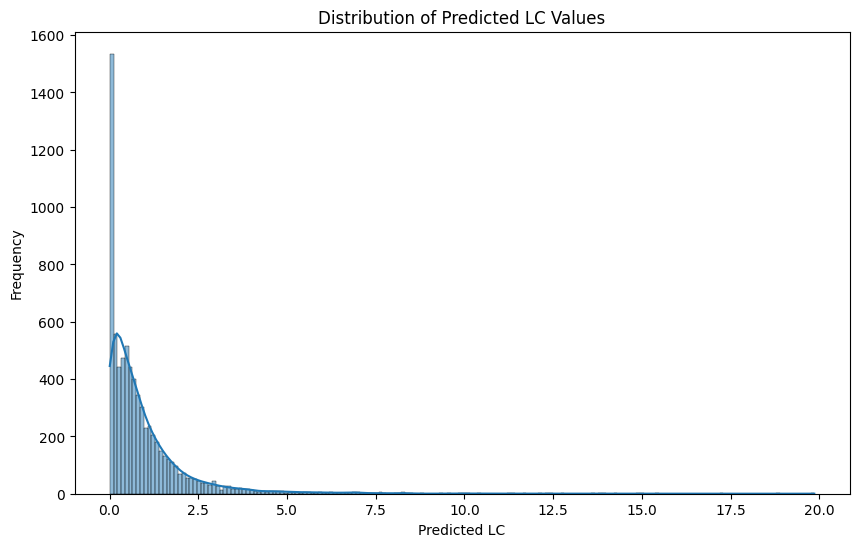

In [ ]:
# prompt: generate a distribution graph for y_pred

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(y_pred
             , kde=True)
plt.title('Distribution of Predicted LC Values')
plt.xlabel('Predicted LC')
plt.ylabel('Frequency')
plt.show()


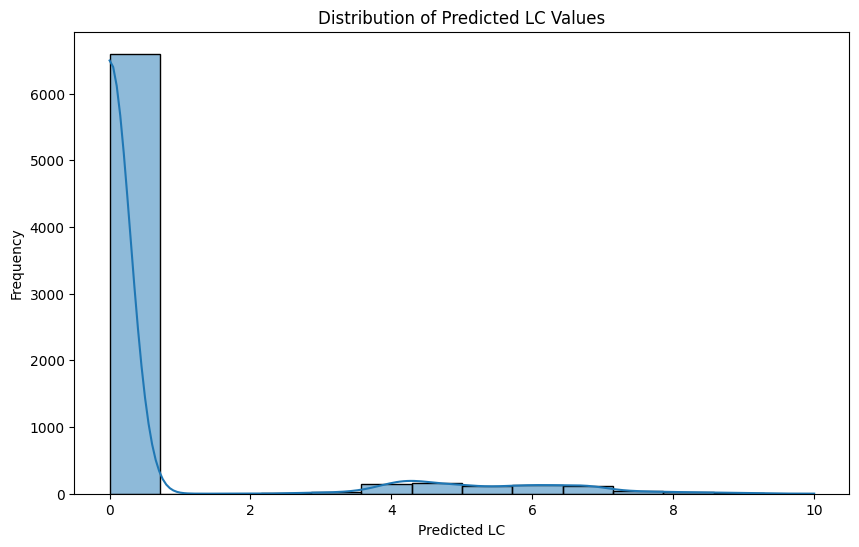

In [ ]:
# prompt: generate a distribution graph for y_pred

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(y_test
             , kde=True)
plt.title('Distribution of Predicted LC Values')
plt.xlabel('Predicted LC')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# two step models (lightGBM)
# get probabilities out of it

#

# Two-Step LightGBM (prob*conditional expected)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3349, number of negative: 26137
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1553
[LightGBM] [Info] Number of data points in the train set: 29486, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113579 -> initscore=-2.054690
[LightGBM] [Info] Start training from score -2.054690


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 3349, number of used features: 33
[LightGBM] [Info] Start training from score 1.688618
MSE (Two-Step LightGBM Model, no outlier removal): 248013.11913111043


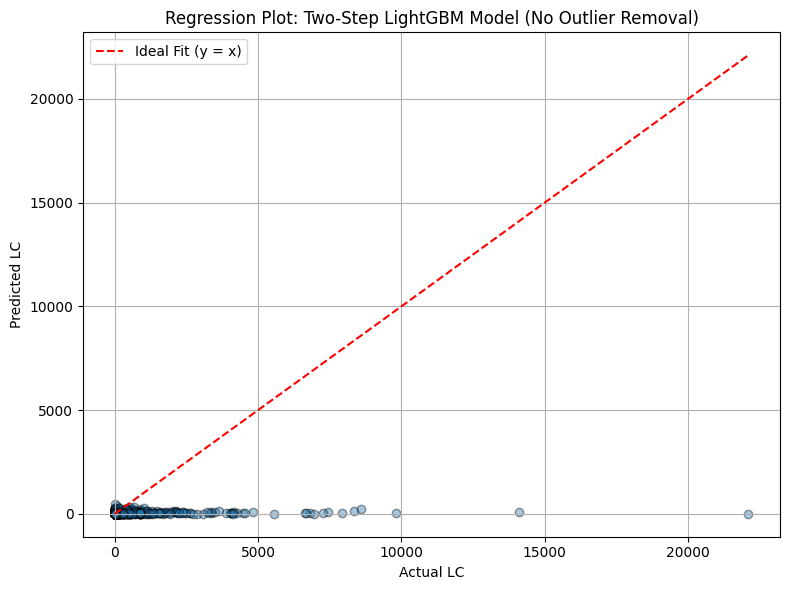

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMClassifier, LGBMRegressor

# ----------------------------
# Load & Preprocess Data
# ----------------------------
df = pd.read_csv("/content/drive/My Drive/DSO530 Final Project/insurance_train.csv")
df['LC'] = df.apply(lambda row: row['X.15'] / row['X.16'] if row['X.16'] > 0 else 0, axis=1)

for col in ['X.2', 'X.5', 'X.6']:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
df['age'] = (pd.to_datetime('2025-04-16') - df['X.5']).dt.days // 365
df['license_years'] = (pd.to_datetime('2025-04-16') - df['X.6']).dt.days // 365
df['policy_years'] = (pd.to_datetime('2025-04-16') - df['X.2']).dt.days // 365

features = [
    'X.7', 'X.8', 'X.9', 'X.10', 'X.11', 'X.12', 'X.13',
    'X.14', 'X.19', 'X.20', 'X.21', 'X.22', 'X.23', 'X.24',
    'X.25', 'X.26', 'X.27', 'X.28', 'age', 'license_years', 'policy_years'
]
df.dropna(subset=features, inplace=True)

X = df[features]
y = df['LC']
y_class = (y > 0).astype(int)  # Binary target for classifier

# ----------------------------
# Train/Test Split
# ----------------------------
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_class = (y_train_reg > 0).astype(int)
y_test_class = (y_test_reg > 0).astype(int)

# ----------------------------
# ColumnTransformer
# ----------------------------
categorical_cols = ['X.7', 'X.13', 'X.19', 'X.20', 'X.21', 'X.26', 'X.27']
numeric_cols = [col for col in features if col not in categorical_cols]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

# ----------------------------
# Step 1: LightGBM Classifier (Probability of LC > 0)
# ----------------------------
clf = LGBMClassifier(random_state=42)
clf.fit(X_train_trans, y_train_class)
proba_pred = clf.predict_proba(X_test_trans)[:, 1]  # Probability LC > 0

# ----------------------------
# Step 2: LightGBM Regressor (Conditional LC | LC > 0)
# ----------------------------
X_train_pos = X_train_trans[y_train_reg > 0]
y_train_pos = np.log1p(y_train_reg[y_train_reg > 0])  # log-transform

X_test_pos = X_test_trans  # Apply to all test points

reg = LGBMRegressor(objective="tweedie", random_state=42)
reg.fit(X_train_pos, y_train_pos)
cond_lc_log_pred = reg.predict(X_test_pos)
cond_lc_pred = np.expm1(cond_lc_log_pred)  # inverse log1p

# ----------------------------
# Final Prediction = Probability × Conditional Expected Value
# ----------------------------
y_final_pred = proba_pred * cond_lc_pred

# ----------------------------
# Evaluate
# ----------------------------
mse_two_step = mean_squared_error(y_test_reg, y_final_pred)
print("MSE (Two-Step LightGBM Model, no outlier removal):", mse_two_step)

# ----------------------------
# Regression Plot
# ----------------------------
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_final_pred, alpha=0.4, edgecolor='k')
plt.plot([0, max(y_test_reg.max(), y_final_pred.max())],
         [0, max(y_test_reg.max(), y_final_pred.max())],
         'r--', label='Ideal Fit (y = x)')
plt.xlabel("Actual LC")
plt.ylabel("Predicted LC")
plt.title("Regression Plot: Two-Step LightGBM Model (No Outlier Removal)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
y_final_pred

array([23.08305941, 19.16508845,  8.13263398, ...,  4.23523098,
       61.65794852,  6.52060151])

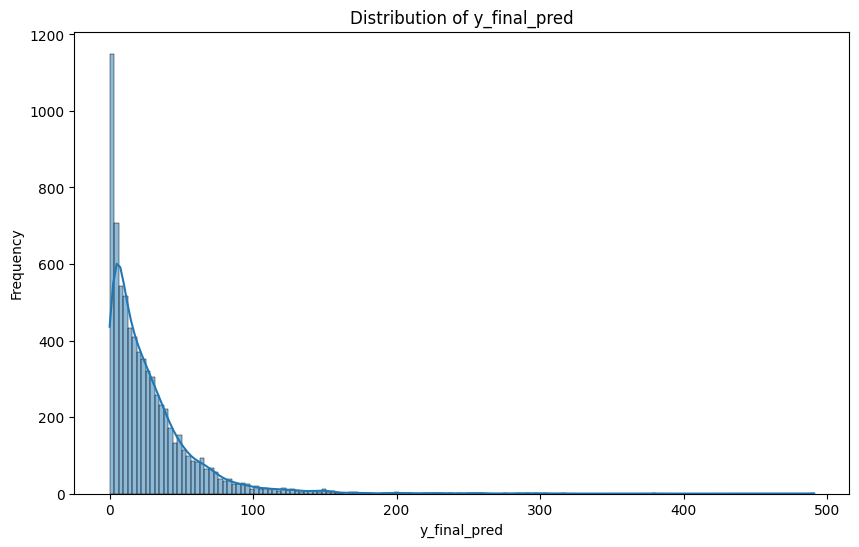

In [ ]:
# prompt: plot a distribution of y_final_pred

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(y_final_pred, kde=True)
plt.title('Distribution of y_final_pred')
plt.xlabel('y_final_pred')
plt.ylabel('Frequency')
plt.show()


 99%|===================| 7294/7372 [00:57<00:00]       

SHAP Summary for Classifier (P(LC > 0))


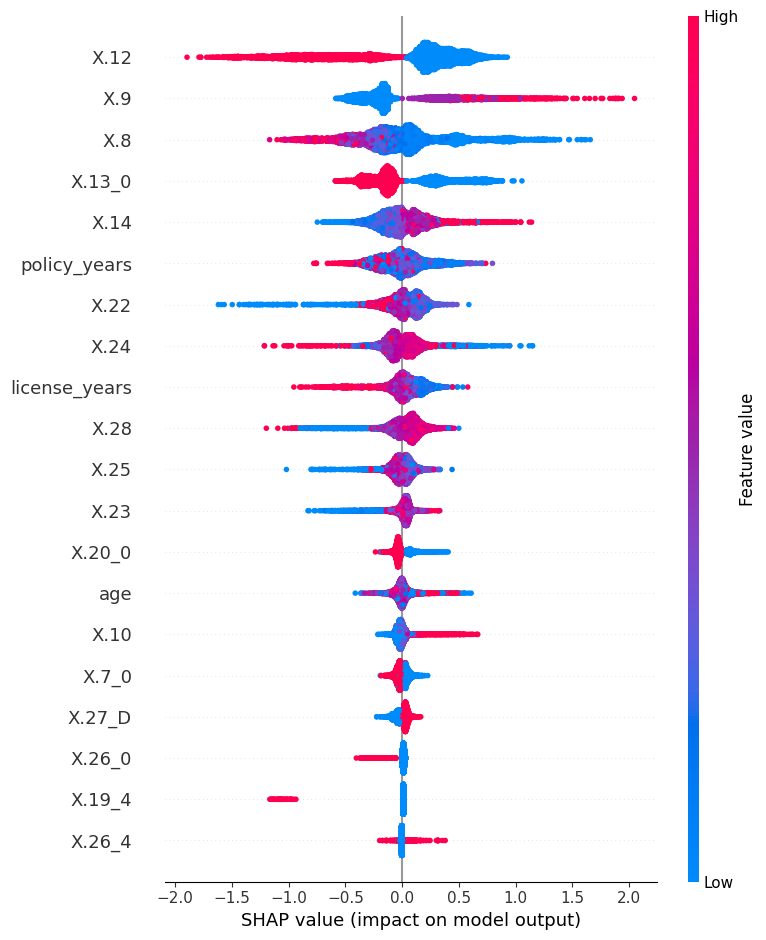

100%|===================| 7348/7372 [00:41<00:00]       

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 1.625877, while the model output was 1.596405. If this difference is acceptable you can set check_additivity=False to disable this check.

In [ ]:
import shap

# Use the same preprocessed X for SHAP
X_sample = pd.DataFrame(X_test_trans, columns=numeric_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)))

# ----------------------------
# SHAP for Classifier
# ----------------------------
explainer_clf = shap.Explainer(clf, X_sample)
shap_values_clf = explainer_clf(X_sample)

print("SHAP Summary for Classifier (P(LC > 0))")
shap.summary_plot(shap_values_clf, X_sample, show=True)


100%|===================| 7358/7372 [01:01<00:00]       

SHAP Summary for Regressor (E[LC | LC > 0])


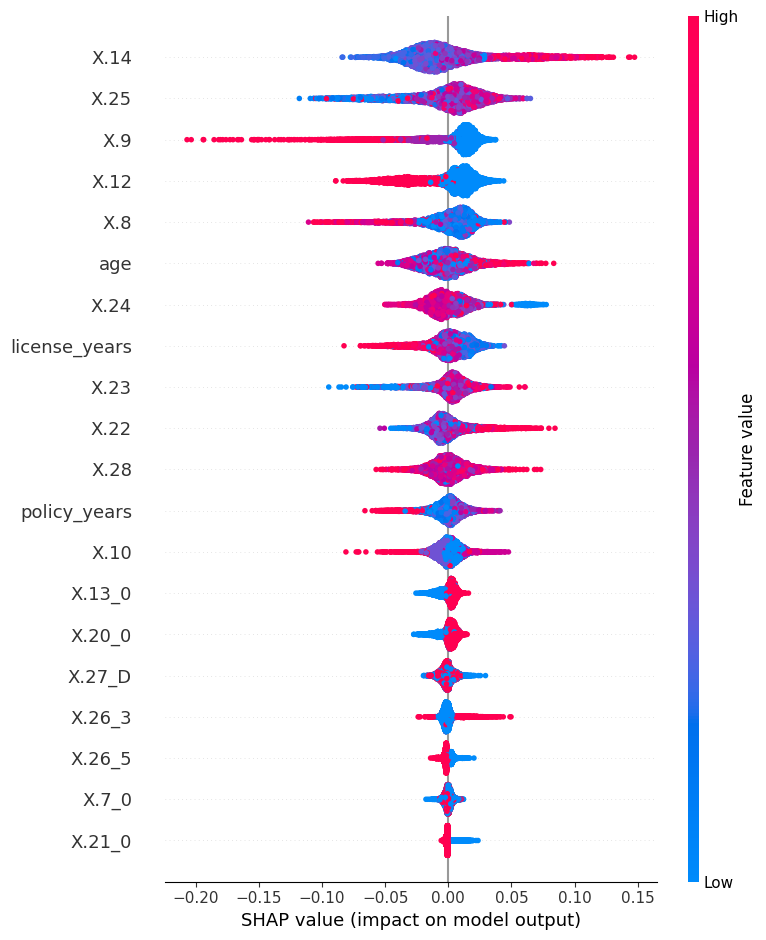

In [ ]:
# ----------------------------
# SHAP for Regressor (LC | LC > 0)
# ----------------------------
# Only use the rows from test set that would go through regression
X_pos_sample = pd.DataFrame(X_test_pos, columns=X_sample.columns)

explainer_reg = shap.Explainer(reg, X_pos_sample)
shap_values_reg = explainer_reg(X_pos_sample, check_additivity=False)


print("SHAP Summary for Regressor (E[LC | LC > 0])")
shap.summary_plot(shap_values_reg, X_pos_sample, show=True)

In [ ]:
# prompt: are there redundant values in X.1?

import pandas as pd

# Assuming 'df' is your DataFrame as defined in the provided code
# Check for redundant values in the 'X.1' column
redundant_x1 = df['X.1'].duplicated(keep=False)  # keep=False marks all duplicates as True

if redundant_x1.any():
  print("There are redundant values in the 'X.1' column.")
  # Example: Show the first few rows with redundant values
  print(df[redundant_x1].head())
else:
  print("There are no redundant values in the 'X.1' column.")


There are no redundant values in the 'X.1' column.


# LightGBM Tweedie


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

# ----------------------------
# Load & Preprocess Data
# ----------------------------
df = pd.read_csv("/content/drive/My Drive/DSO530 Final Project/insurance_train.csv")
df['LC'] = df.apply(lambda row: row['X.15'] / row['X.16'] if row['X.16'] > 0 else 0, axis=1)

for col in ['X.2', 'X.5', 'X.6']:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
df['age'] = (pd.to_datetime('2025-04-16') - df['X.5']).dt.days // 365
df['license_years'] = (pd.to_datetime('2025-04-16') - df['X.6']).dt.days // 365
df['policy_years'] = (pd.to_datetime('2025-04-16') - df['X.2']).dt.days // 365

features = [
    'X.7', 'X.8', 'X.9', 'X.10', 'X.11', 'X.12', 'X.13',
    'X.14', 'X.19', 'X.20', 'X.21', 'X.22', 'X.23', 'X.24',
    'X.25', 'X.26', 'X.27', 'X.28', 'age', 'license_years', 'policy_years'
]
df.dropna(subset=features, inplace=True)

X = df[features]
y = df['LC']

# ----------------------------
# Split & Transform Features
# ----------------------------
X_train, X_test, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_cols = ['X.7', 'X.13', 'X.19', 'X.20', 'X.21', 'X.26', 'X.27']
numeric_cols = [col for col in features if col not in categorical_cols]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

# ----------------------------
# Log-transform the target
# ----------------------------
y_train = np.log1p(y_train_raw)
y_test = np.log1p(y_test_raw)



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1553
[LightGBM] [Info] Number of data points in the train set: 29486, number of used features: 34
[LightGBM] [Info] Start training from score -0.486636


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


MSE with LightGBM: 253038.94180380355


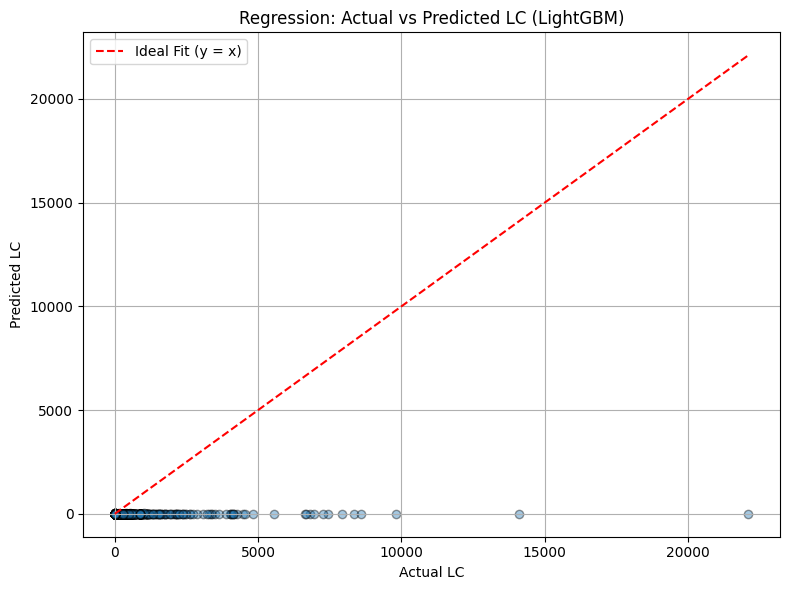

In [ ]:
# ----------------------------
# LightGBM Tweedie Model
# ----------------------------
model = LGBMRegressor(objective='tweedie', tweedie_variance_power=1.5, random_state=42)
model.fit(X_train_trans, y_train)

# ----------------------------
# Predict & Evaluate
# ----------------------------
y_pred_log = model.predict(X_test_trans)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

mse = mean_squared_error(y_true, y_pred)
print("MSE with LightGBM:", mse)

# ----------------------------
# Plot Actual vs Predicted
# ----------------------------
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.4, edgecolor='k')
plt.plot([0, max(y_true.max(), y_pred.max())],
         [0, max(y_true.max(), y_pred.max())],
         'r--', label='Ideal Fit (y = x)')
plt.xlabel("Actual LC")
plt.ylabel("Predicted LC")
plt.title("Regression: Actual vs Predicted LC (LightGBM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



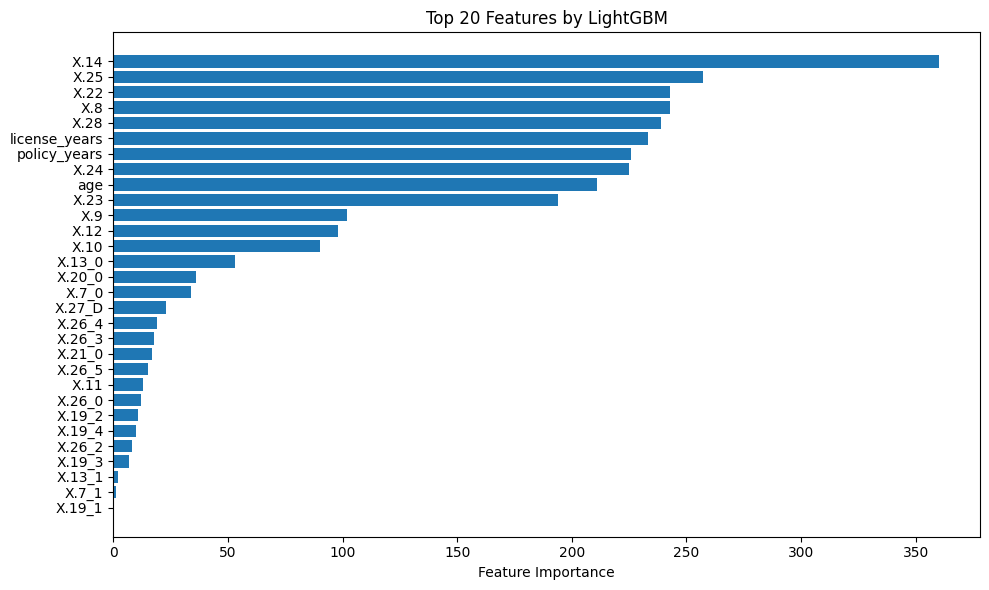

In [ ]:
# ----------------------------
# Feature Importance Plot
# ----------------------------
# Extract feature names from the ColumnTransformer
onehot_feature_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
all_feature_names = numeric_cols + onehot_feature_names

importances = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'][:30][::-1], importance_df['importance'][:30][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Features by LightGBM")
plt.tight_layout()
plt.show()

 99%|===================| 7323/7372 [00:47<00:00]       

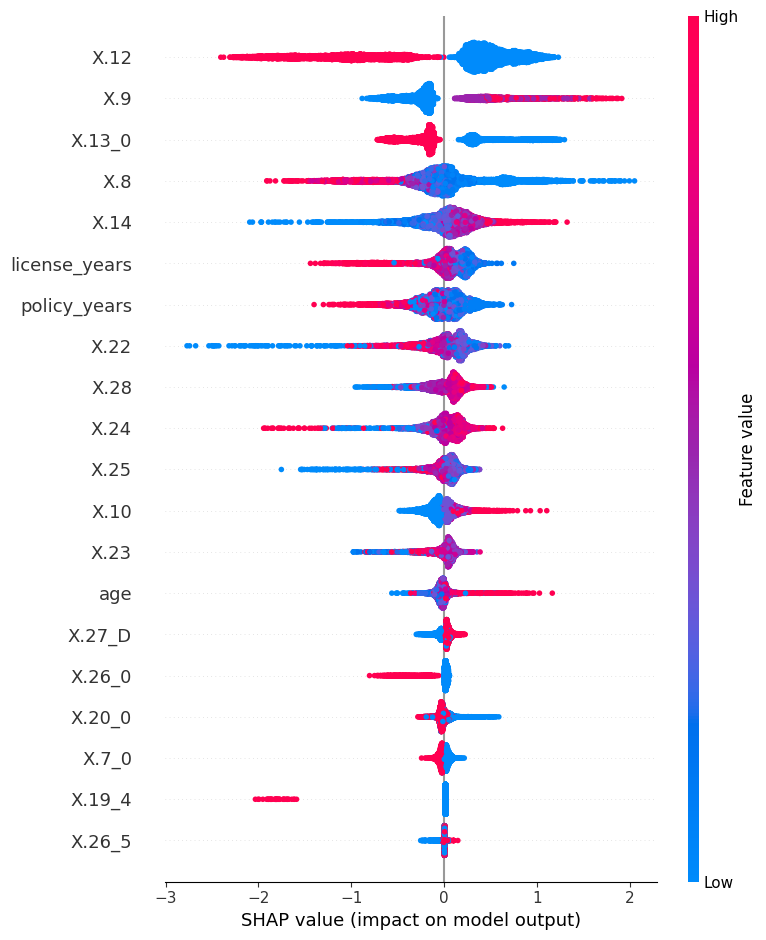

In [ ]:
import shap

# Create DataFrame with the same feature names used in training
X_test_df = pd.DataFrame(X_test_trans, columns=all_feature_names)

# SHAP Explainer for the LightGBM model
explainer = shap.Explainer(model, X_test_df)
shap_values = explainer(X_test_df, check_additivity=False)  # Disable check for Tweedie

# SHAP Summary Plot (Feature Strength)
shap.summary_plot(shap_values, X_test_df, plot_type="dot", show=True)


In [ ]:
# Updated list of low-importance features to drop
drop_features = [
    'X.13_1', 'X.7_1', 'X.19_1', 'X.19_2', 'X.19_3', 'X.19_4',
    'X.26_0', 'X.26_2', 'X.26_5'
]

# Original setup
categorical_cols = ['X.7', 'X.13', 'X.19', 'X.20', 'X.21', 'X.26', 'X.27']
numeric_cols = [col for col in features if col not in categorical_cols]

# Redefine ColumnTransformer, then manually drop columns later
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

# Rebuild feature names to drop columns by name
onehot_feature_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
all_feature_names = numeric_cols + onehot_feature_names

import pandas as pd
# Rebuild feature names to drop columns by name
onehot_feature_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
all_feature_names = numeric_cols + onehot_feature_names

X_train_df = pd.DataFrame(X_train_trans, columns=all_feature_names)
X_test_df = pd.DataFrame(X_test_trans, columns=all_feature_names)

# Drop low-importance features
X_train_reduced = X_train_df.drop(columns=drop_features, errors='ignore')
X_test_reduced = X_test_df.drop(columns=drop_features, errors='ignore')

# Retrain model
from lightgbm import LGBMRegressor
model_reduced = LGBMRegressor(objective='tweedie', tweedie_variance_power=1.5, random_state=42)
model_reduced.fit(X_train_reduced, y_train)

# Predict & Evaluate
y_pred_log_reduced = model_reduced.predict(X_test_reduced)
y_pred_reduced = np.expm1(y_pred_log_reduced)
y_true = np.expm1(y_test)

mse_reduced = mean_squared_error(y_true, y_pred_reduced)
print("MSE after dropping low-importance features:", mse_reduced)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1535
[LightGBM] [Info] Number of data points in the train set: 29486, number of used features: 25
[LightGBM] [Info] Start training from score -0.486636
MSE after dropping low-importance features: 253027.95612379516


# XGBoost Tweedie


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# === Load Dataset ===
df = pd.read_csv("/content/drive/My Drive/DSO530 Final Project/insurance_train.csv")

# === Create Target Variables ===
df['LC'] = df.apply(lambda row: row['X.15'] / row['X.16'] if row['X.16'] > 0 else 0, axis=1)
df['log_LC'] = np.log1p(df['LC'])

# === Date Conversion & Feature Engineering ===
for col in ['X.2', 'X.5', 'X.6']:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')

today = pd.to_datetime("today")
df['age'] = (today - df['X.5']).dt.days // 365
df['license_years'] = (today - df['X.6']).dt.days // 365
df['policy_years'] = (today - df['X.2']).dt.days // 365
df = df.dropna(subset=['age', 'license_years', 'policy_years'])

# === Drop Leakage Columns & Define X, y ===
leakage_cols = ['X.1', 'X.2', 'X.5', 'X.6', 'X.15', 'X.16', 'X.17', 'X.18', 'LC', 'log_LC']
X = df.drop(columns=leakage_cols)
y = df['log_LC']

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Preprocessing Pipeline ===
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])

# === Transform Data ===
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)



XGBoost MSE (original LC scale): 783206.3577


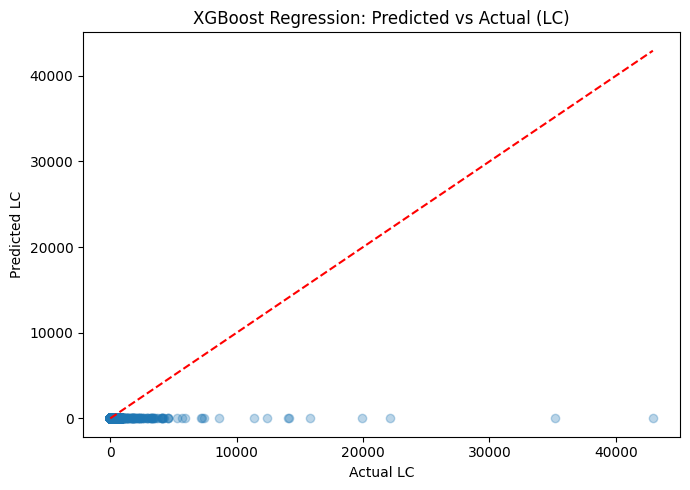

In [ ]:

# === Train XGBoost Regressor ===
model = xgb.XGBRegressor(objective='reg:tweedie',
                          n_estimators=100)
model.fit(X_train_transformed, y_train)

# === Predict (log scale) ===
y_pred_log = model.predict(X_test_transformed)

# === Inverse transform to original LC scale ===
y_pred = np.expm1(y_pred_log)
y_actual = np.expm1(y_test)

# === Evaluate MSE in original scale ===
mse = mean_squared_error(y_actual, y_pred)
print(f"XGBoost MSE (original LC scale): {mse:.4f}")

# === Regression Plot (Original Scale) ===
plt.figure(figsize=(7, 5))
plt.scatter(y_actual, y_pred, alpha=0.3)
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--')
plt.xlabel("Actual LC")
plt.ylabel("Predicted LC")
plt.title("XGBoost Regression: Predicted vs Actual (LC)")
plt.tight_layout()
plt.show()


# Neural Network

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# -------------------------
# 1. Load and preprocess data
# -------------------------
df = pd.read_csv("/content/drive/My Drive/DSO530 Final Project/insurance_train.csv")

# Create target variable LC (make sure X.16 != 0)
df['LC'] = df.apply(lambda row: row['X.15'] / row['X.16'] if row['X.16'] > 0 else 0, axis=1)

# Example: derive features (you can add more engineered features)
for col in ['X.2', 'X.5', 'X.6']:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')

today = pd.to_datetime('2025-04-17')
df['age'] = (today - df['X.5']).dt.days // 365
df['license_years'] = (today - df['X.6']).dt.days // 365

# Drop high leakage columns and target
drop_cols = ['X.15', 'X.16', 'LC', 'X.2', 'X.5', 'X.6']  # add more as needed
X = df.drop(columns=drop_cols).select_dtypes(include=[np.number]).fillna(0)
y = df['LC']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# -------------------------
# 2. Define Tweedie loss
# -------------------------
def tweedie_loss(power=1.5):
    def loss(y_true, y_pred):
        eps = 1e-6
        y_pred = tf.maximum(y_pred, eps)
        return tf.reduce_mean((tf.pow(y_pred, 2 - power) / (2 - power)) - (y_true * tf.pow(y_pred, 1 - power) / (1 - power)))
    return loss

# -------------------------
# 3. Build and train model
# -------------------------
input_dim = x_train.shape[1]

model = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss=tweedie_loss(power=1.5))
model.summary()

model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# -------------------------
# 4. Predict and evaluate
# -------------------------
preds_nn = model.predict(x_test).flatten()
mse = mean_squared_error(y_test, preds_nn)
print(f"Mean Squared Error (Neural Network): {mse:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,585 (14.00 KB)

 Trainable params: 3,585 (14.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2997.6709 - val_loss: 46.5838
Epoch 2/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 35.7174 - val_loss: 35.3932
Epoch 3/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 28.3525 - val_loss: 31.0133
Epoch 4/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 26.1316 - val_loss: 28.0400
Epoch 5/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 23.9110 - val_loss: 25.3495
Epoch 6/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 88.9852 - val_loss: 43.4356
Epoch 7/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 157.6077 - val_loss: 22.8612
Epoch 8/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 48.3316 - val_loss: 315.2840
Epoch 9/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 295.9205 - val_loss: 314.7771
Epoch 10/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 50.4370 - val_loss: 314.6291
Epoch 11/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 24.4634 - val_loss: 364.5074
Epoch 12/50
749/749 ━

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import itertools

# -------------------------
# 1. Load & Preprocess Data
# -------------------------
df = pd.read_csv("/content/drive/My Drive/DSO530 Final Project/insurance_train.csv")

# Create LC
df['LC'] = df.apply(lambda row: row['X.15'] / row['X.16'] if row['X.16'] > 0 else 0, axis=1)

# Feature engineering
for col in ['X.2', 'X.5', 'X.6']:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
today = pd.to_datetime("2025-04-17")
df['age'] = (today - df['X.5']).dt.days // 365
df['license_years'] = (today - df['X.6']).dt.days // 365

# Select features & target
drop_cols = ['X.15', 'X.16', 'LC', 'X.2', 'X.5', 'X.6']
X = df.drop(columns=drop_cols).select_dtypes(include=[np.number]).fillna(0)
y = df['LC']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split train/test
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to arrays
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
input_dim = x_train.shape[1]

# -------------------------
# 2. Define Tweedie Loss
# -------------------------
def tweedie_loss(power=1.5):
    def loss(y_true, y_pred):
        eps = 1e-6
        y_pred = tf.maximum(y_pred, eps)
        return tf.reduce_mean((tf.pow(y_pred, 2 - power) / (2 - power)) - (y_true * tf.pow(y_pred, 1 - power) / (1 - power)))
    return loss

# -------------------------------
# 3. Model Builder
# -------------------------------
def build_model(units, dropout_rate, learning_rate, num_layers):
    model = Sequential()
    model.add(Dense(units=units, activation='relu', input_shape=(input_dim,)))
    for _ in range(num_layers):
        model.add(Dense(units=units, activation='relu'))
        if dropout_rate > 0:
            model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=tweedie_loss(power=1.5))
    return model

# -------------------------------
# 4. Grid Search with K-Fold CV
# -------------------------------
param_grid = {
    'units': [32, 64],
    'dropout_rate': [0.0, 0.2],
    'learning_rate': [0.001, 0.01],
    'num_layers': [1, 2],
    'epochs': [50],
    'batch_size': [32]
}

keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

kf = KFold(n_splits=3, shuffle=True, random_state=42)
best_score = np.inf
best_params = None

for comb in combinations:
    print("Evaluating combination:", comb)
    cv_losses = []

    for train_idx, val_idx in kf.split(x_train):
        X_tr, X_val = x_train[train_idx], x_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model = build_model(comb['units'], comb['dropout_rate'],
                            comb['learning_rate'], comb['num_layers'])

        model.fit(X_tr, y_tr,
                  epochs=comb['epochs'],
                  batch_size=comb['batch_size'],
                  verbose=0)

        loss = model.evaluate(X_val, y_val, verbose=0)
        cv_losses.append(loss)

    avg_cv_loss = np.mean(cv_losses)
    print("Average CV Loss:", avg_cv_loss)

    if avg_cv_loss < best_score:
        best_score = avg_cv_loss
        best_params = comb.copy()

print("\n✅ Best CV Loss:", best_score)
print("✅ Best Hyperparameters:", best_params)

# -------------------------------
# 5. Final Model on Full Train Set
# -------------------------------
best_model = build_model(units=best_params['units'],
                         dropout_rate=best_params['dropout_rate'],
                         learning_rate=best_params['learning_rate'],
                         num_layers=best_params['num_layers'])

best_model.fit(x_train, y_train,
               epochs=best_params['epochs'],
               batch_size=best_params['batch_size'],
               verbose=0)

# Predict & Evaluate
preds_nn_tuned = best_model.predict(x_test).flatten()
mse_nn_tuned = mean_squared_error(y_test, preds_nn_tuned)
print(f"\n🎯 Mean Squared Error (Tuned NN): {mse_nn_tuned:.4f}")


Evaluating combination: {'units': 32, 'dropout_rate': 0.0, 'learning_rate': 0.001, 'num_layers': 1, 'epochs': 50, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Average CV Loss: 1761.8519694010417
Evaluating combination: {'units': 32, 'dropout_rate': 0.0, 'learning_rate': 0.001, 'num_layers': 2, 'epochs': 50, 'batch_size': 32}
Average CV Loss: 1347.0702718098958
Evaluating combination: {'units': 32, 'dropout_rate': 0.0, 'learning_rate': 0.01, 'num_layers': 1, 'epochs': 50, 'batch_size': 32}
Average CV Loss: 6629.839762369792
Evaluating combination: {'units': 32, 'dropout_rate': 0.0, 'learning_rate': 0.01, 'num_layers': 2, 'epochs': 50, 'batch_size': 32}
Average CV Loss: 95623.115234375
Evaluating combination: {'units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'num_layers': 1, 'epochs': 50, 'batch_size': 32}
Average CV Loss: 904.0495402018229
Evaluating combination: {'units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'num_layers': 2, 'epochs': 50, 'batch_size': 32}
Average CV Loss: 1559.8318684895833
Evaluating combination: {'units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'num_layers': 1, 'epochs': 50, 'batch_size': 32}
